In [1]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from metadata.etfs import etfs_large, etfs_small

warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [2]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl

def calculateRollingSharpeRatio(dfPnl, window = 3, annulaize = 12, rf = 0):
    rolling_mean = (dfPnl.rolling(window=window).mean() - rf) 
    rolling_std = dfPnl.rolling(window=window).std()

    # replace zeros with NaNs
    rolling_std = rolling_std.replace(0, np.nan)

    rolling_sr = rolling_mean / rolling_std * np.sqrt(annulaize)

    return rolling_sr

def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateExpectedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

def calculateVolatility(dfPnl, annualize = 12):
    v = dfPnl.std() * annualize * 100
    return v

def calculateSortino(dfPnl, annualize = 12):
    
    # portfolio downside vol
    downside_rets = dfPnl.copy()
    downside_rets[downside_rets >= 0] = np.nan
    downside_vol = downside_rets[~pd.isna(downside_rets)].std()

    # portfolio sharpe
    sortino_ratio = (dfPnl.mean() / downside_vol) * annualize

    return sortino_ratio

def calculateAvgDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    avg_drawdown = drawdown.mean() * 100

    return avg_drawdown

def calculateMaxDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    max_drawdown = drawdown.min() * 100

    return max_drawdown

In [13]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

fs_methods_tags = {
    "sfstscv_nocluster": "Sequential FS",
    "dynotears_nocluster": "Dynotears",
    "lasso1_nocluster": "Lasso",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "multivariate-granger_nocluster": "Multivariate Granger",
    "dynotears_rollingcluster_k5": "Dynotears",
    "var-lingam_rollingcluster_k5": "VAR-LiNGAM",

}
fs_methods = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "multivariate-granger_nocluster",
    "pairwise-granger_nocluster",
]
metric_funcs = {
    "E[Rt]": calculateExpectedReturn,
    "Volatility": calculateVolatility,
    "Sharpe": calculateSharpeRatio,
    "Sortino": calculateSortino,
    "AvgDD": calculateAvgDD,
    "MaxDD": calculateMaxDD,    
}

In [14]:
all_pnl = []
all_measures = []
for etf in etfs_large:
    for i, fs in enumerate(fs_methods):
        files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))

        if len(files) != 1:
            # raise ValueError(f"Found {len(files)} files for {etf} and {fs}.")
            continue

        for f in files:
            dfPred = load_pickle(f)["predictions"]
            # dfPred = np.log(1 + dfPred / 100)
            
            # run backtest
            bt = backtester(dfPred)
            bt.simpleStrategy()

                # extract pnl
            if i == 0:
                dfPnl = dfPred[["true"]].copy()
                dfPnl.columns = [etf]
            dfPnl[fs_methods_tags[fs]] = bt.pnl
    
    # save pnl
    melt_dfPnl = dfPnl.reset_index().melt("date")
    melt_dfPnl["etf"] = etf
    all_pnl.append(melt_dfPnl)

    # calculate portfolio performance measures
    measures = []
    for tag, performance_measure in metric_funcs.items():
        measure = performance_measure(dfPnl)
        measures.append(pd.DataFrame(measure, columns=[tag]))

    # calculate portfolio performance measures on crisis periods
    pnl_gfc_df = dfPnl.loc["2007-07-01":"2008-11-01"]
    pnl_dj_flash_crash_df = dfPnl.loc["2010-03-01":"2010-07-01"]
    pnl_tsunami_fukushima_df = dfPnl.loc["2011-01-01":"2011-05-01"]
    pnl_black_monday_df = dfPnl.loc["2011-06-01":"2011-10-01"]
    pnl_chinese_black_monday_df = dfPnl.loc["2015-06-01":"2015-10-01"]
    pnl_dj_plunge_df = dfPnl.loc["2018-01-01":"2018-05-01"]
    pnl_covid_df = dfPnl.loc["2020-01-01":"2020-05-01"]

    crisis_pnl = [
        pnl_gfc_df, pnl_dj_flash_crash_df, pnl_tsunami_fukushima_df, 
        pnl_black_monday_df, pnl_chinese_black_monday_df, pnl_dj_plunge_df, pnl_covid_df
                ]

    crisis_pnl_df = pd.concat(crisis_pnl)
    crisis_measures = []
    for tag, performance_measure in metric_funcs.items():
        crisis_measure = performance_measure(dfPnl)
        crisis_measures.append(pd.DataFrame(crisis_measure, columns=[f"{tag}_crisis"]))
    

    measures_df = pd.concat(measures, axis=1)
    melt_measures_df = measures_df.reset_index().melt("index")
    melt_measures_df["etf"] = etf

    crisis_measures_df = pd.concat(crisis_measures, axis=1)
    melt_crisis_measures_df = crisis_measures_df.reset_index().melt("index")
    melt_crisis_measures_df["etf"] = etf

    melt_measures_df = pd.concat([melt_measures_df, melt_crisis_measures_df], axis=0)

    all_measures.append(melt_measures_df)

all_measures_df = pd.concat(all_measures)
all_pnl_df = pd.concat(all_pnl)

### Plot Correlation Matrices

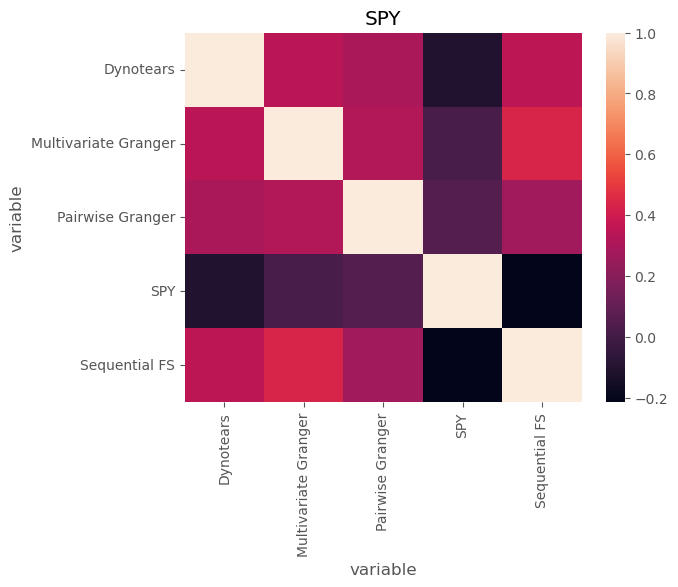

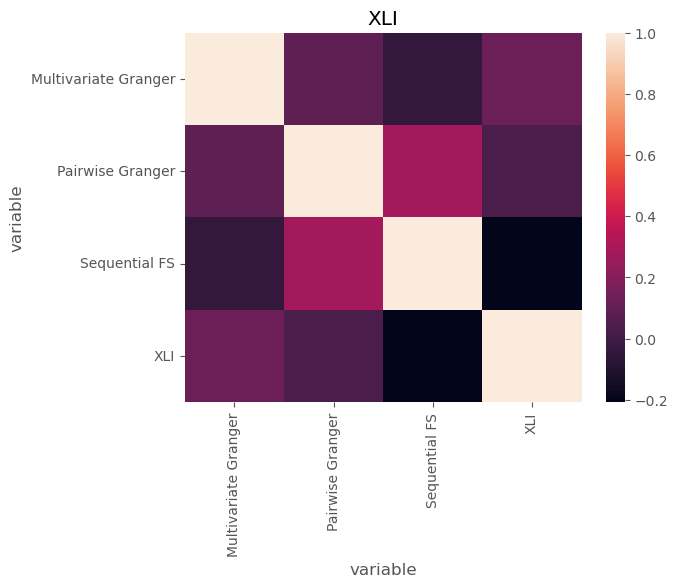

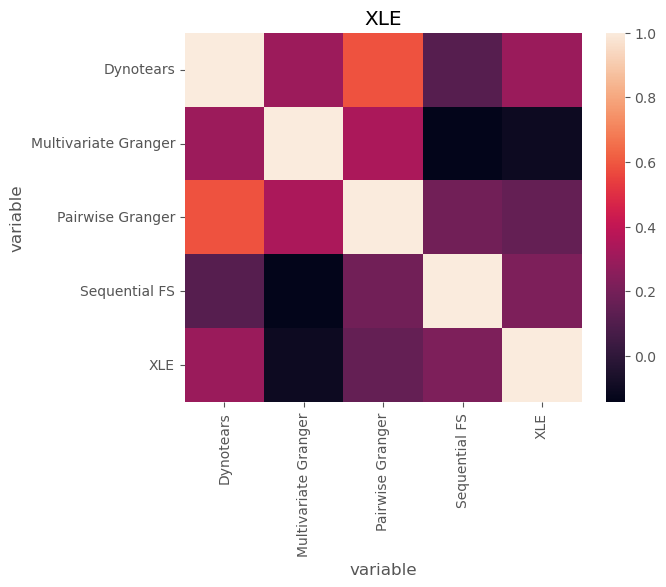

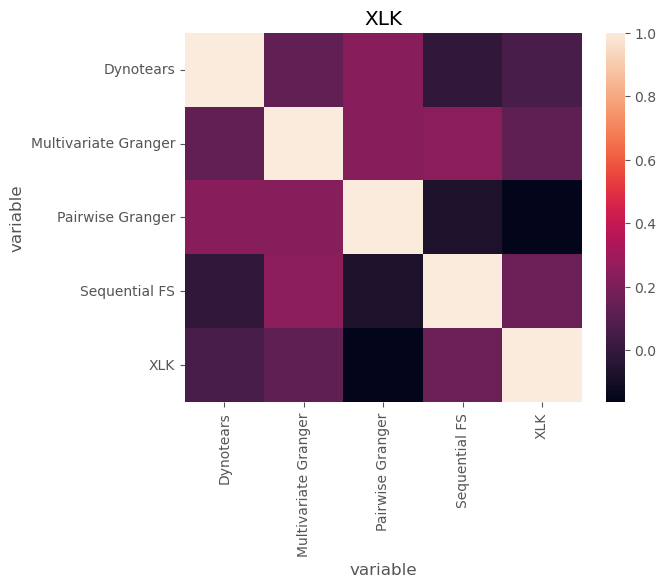

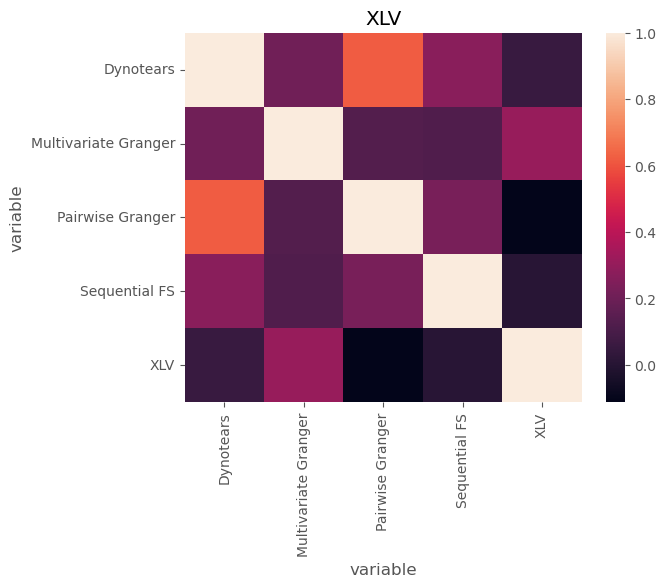

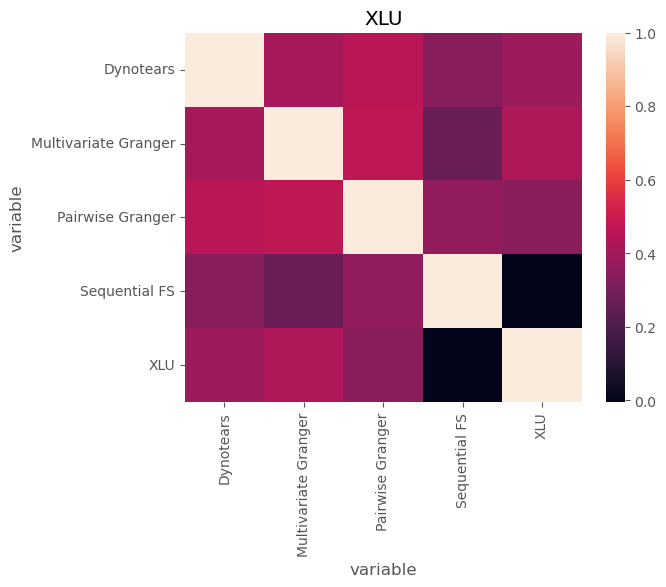

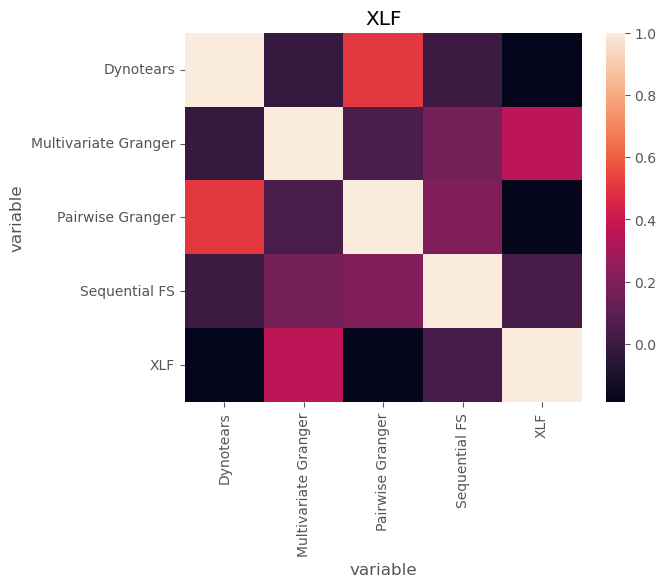

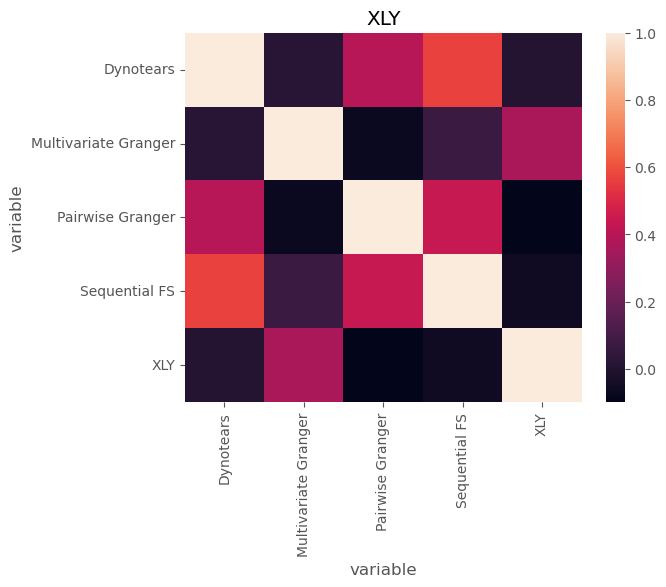

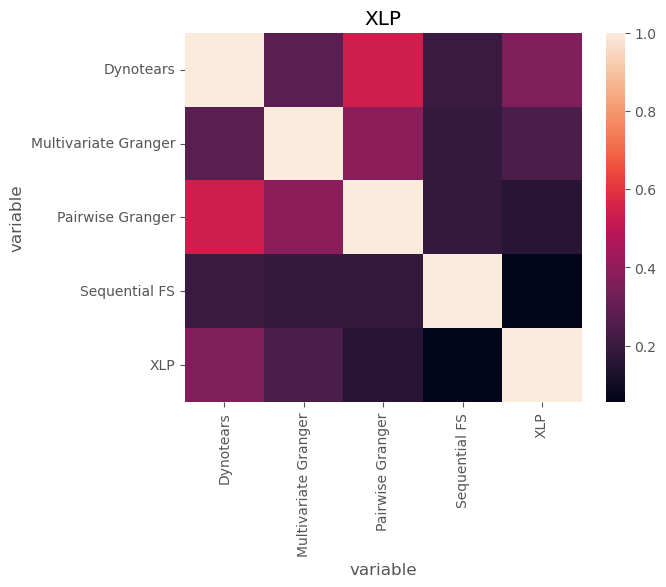

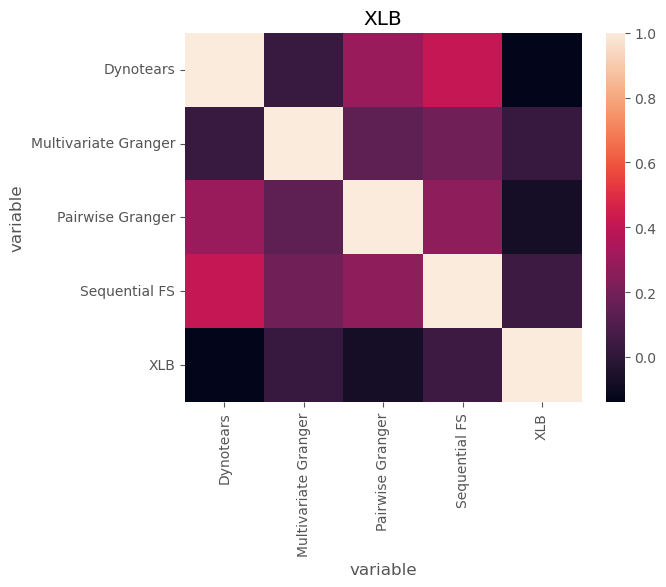

In [15]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    corr = tmp_dfPnl.corr()

    sns.heatmap(corr)
    plt.title(target)
    plt.show()

### Boxplot Portfolio Metrics

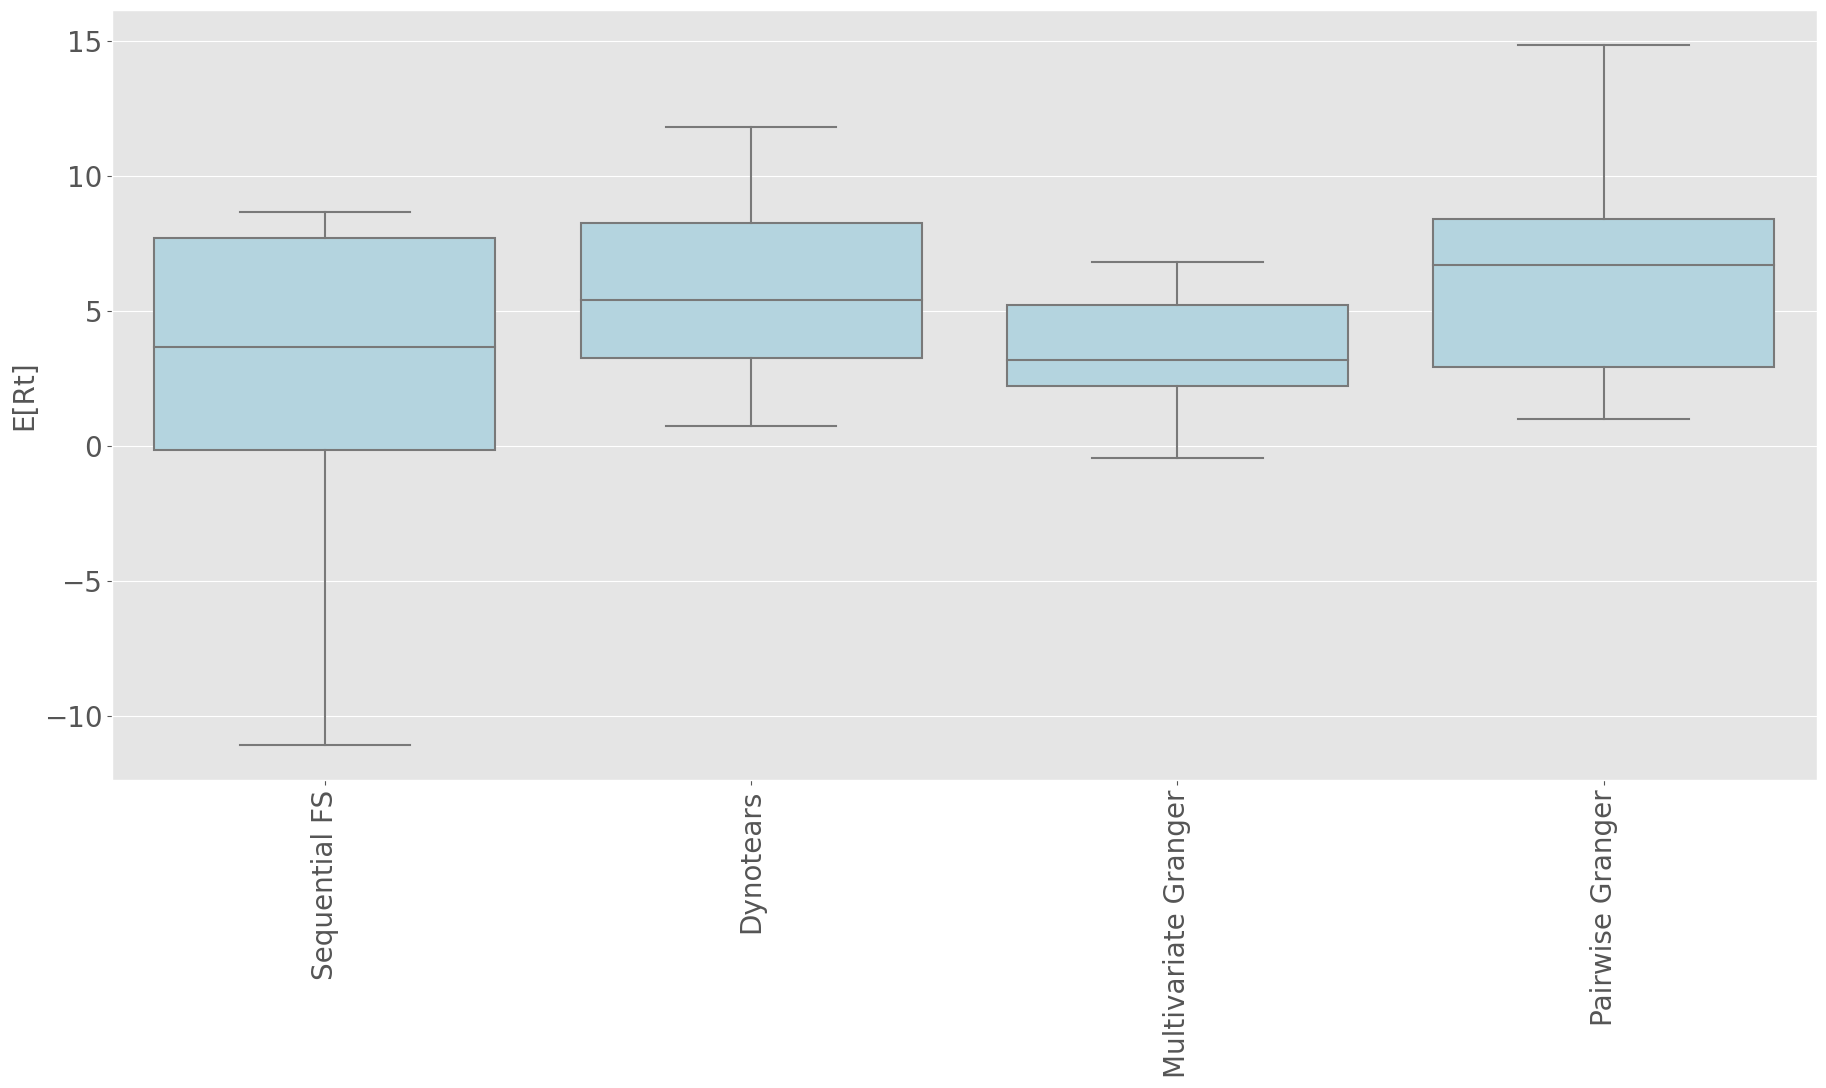

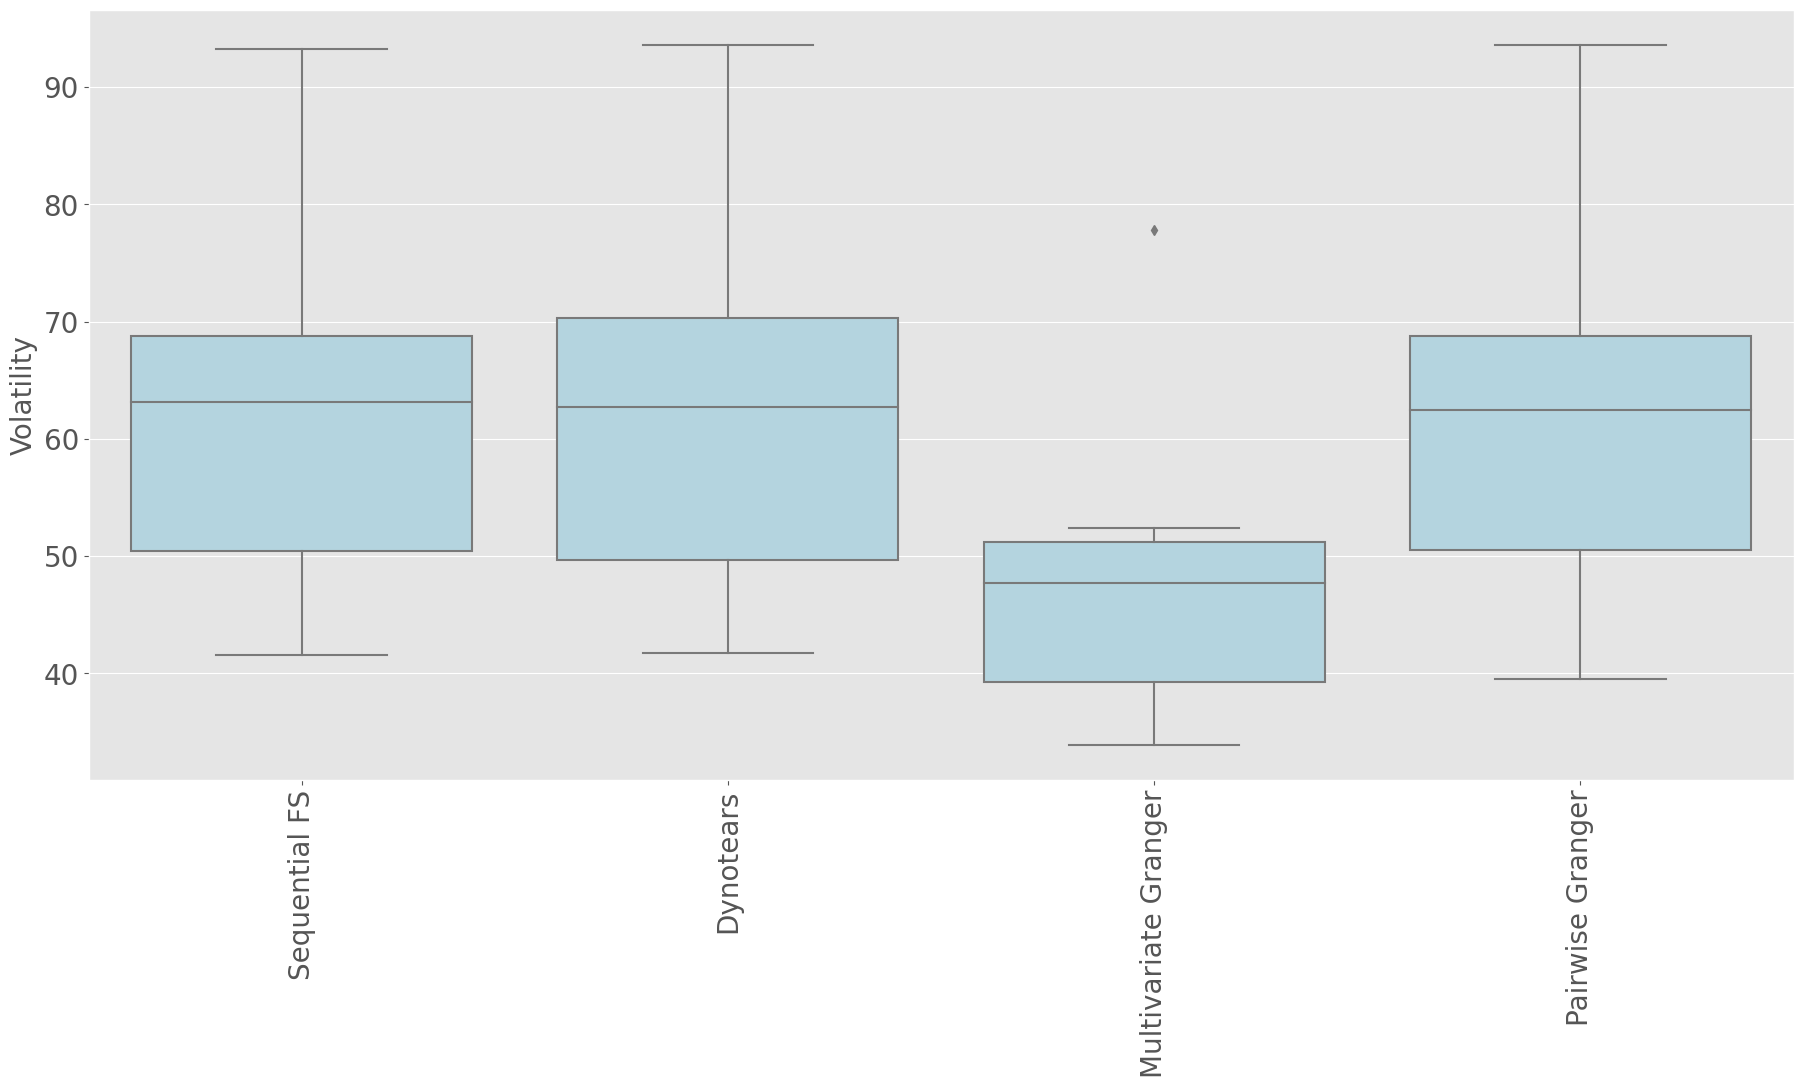

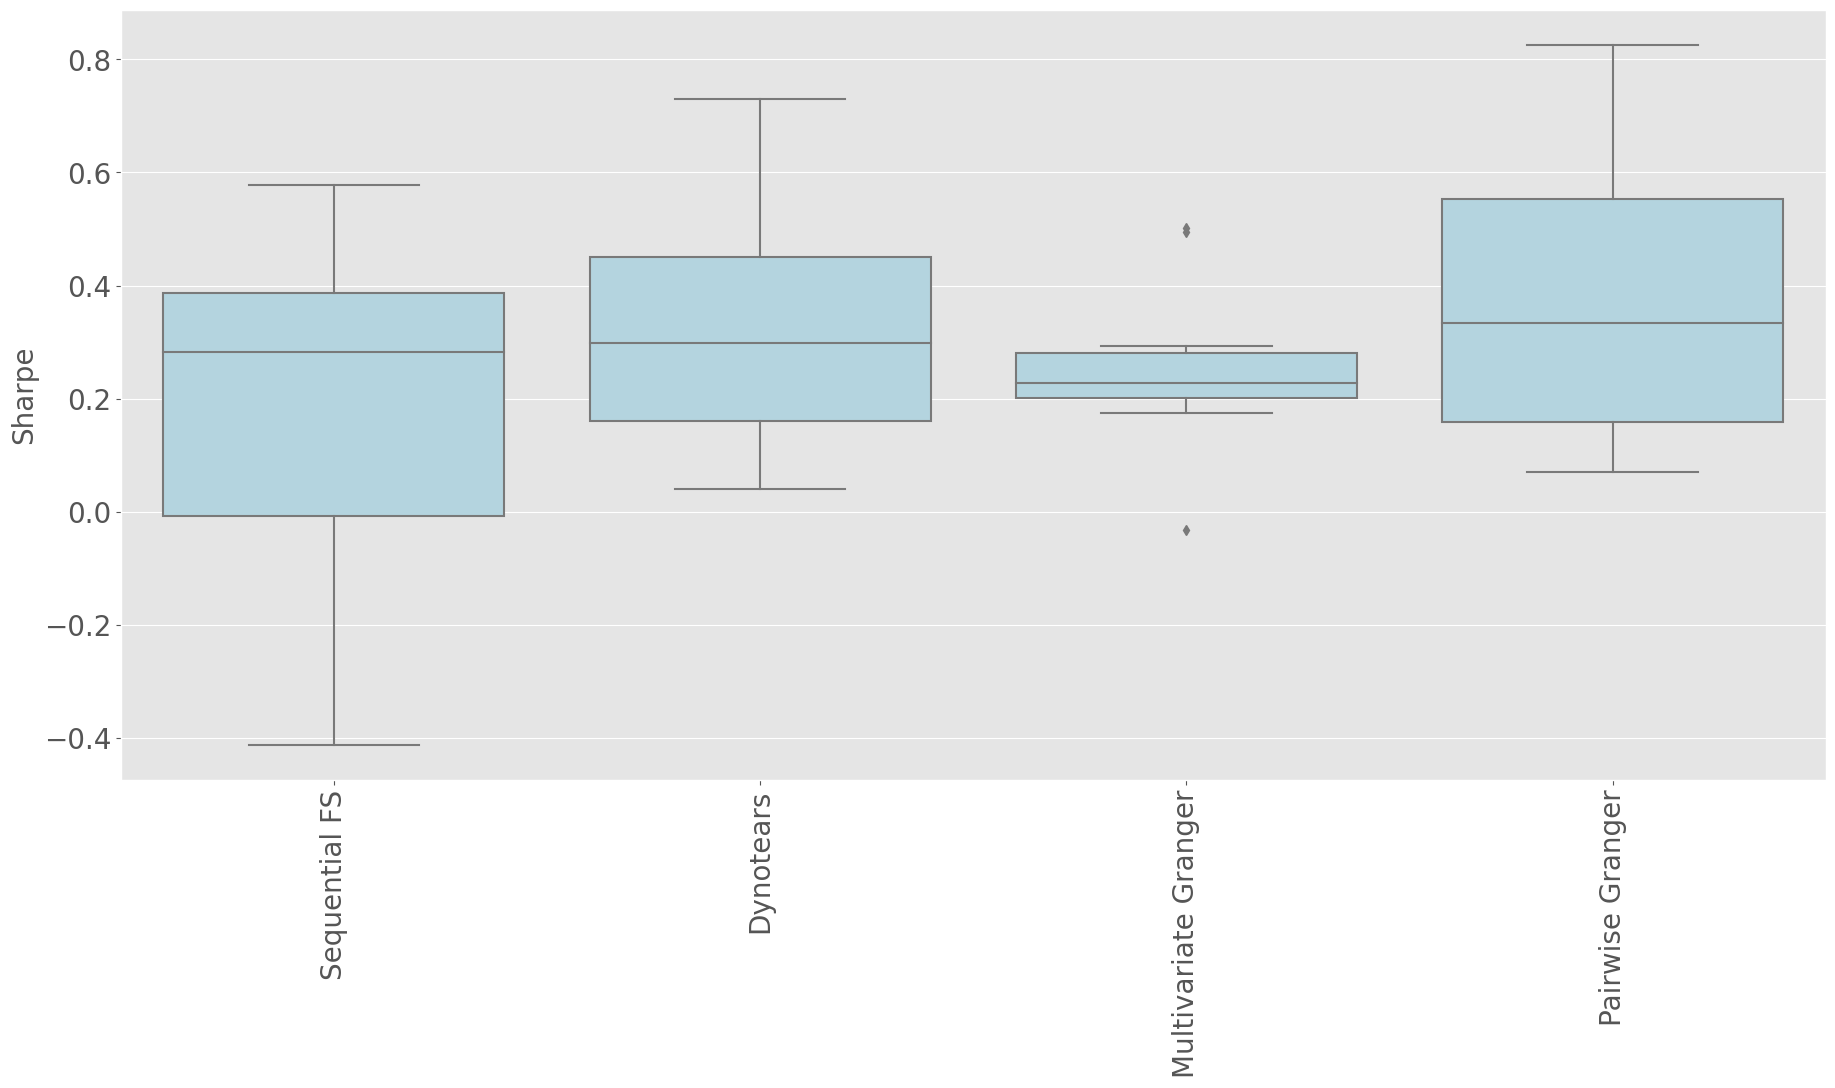

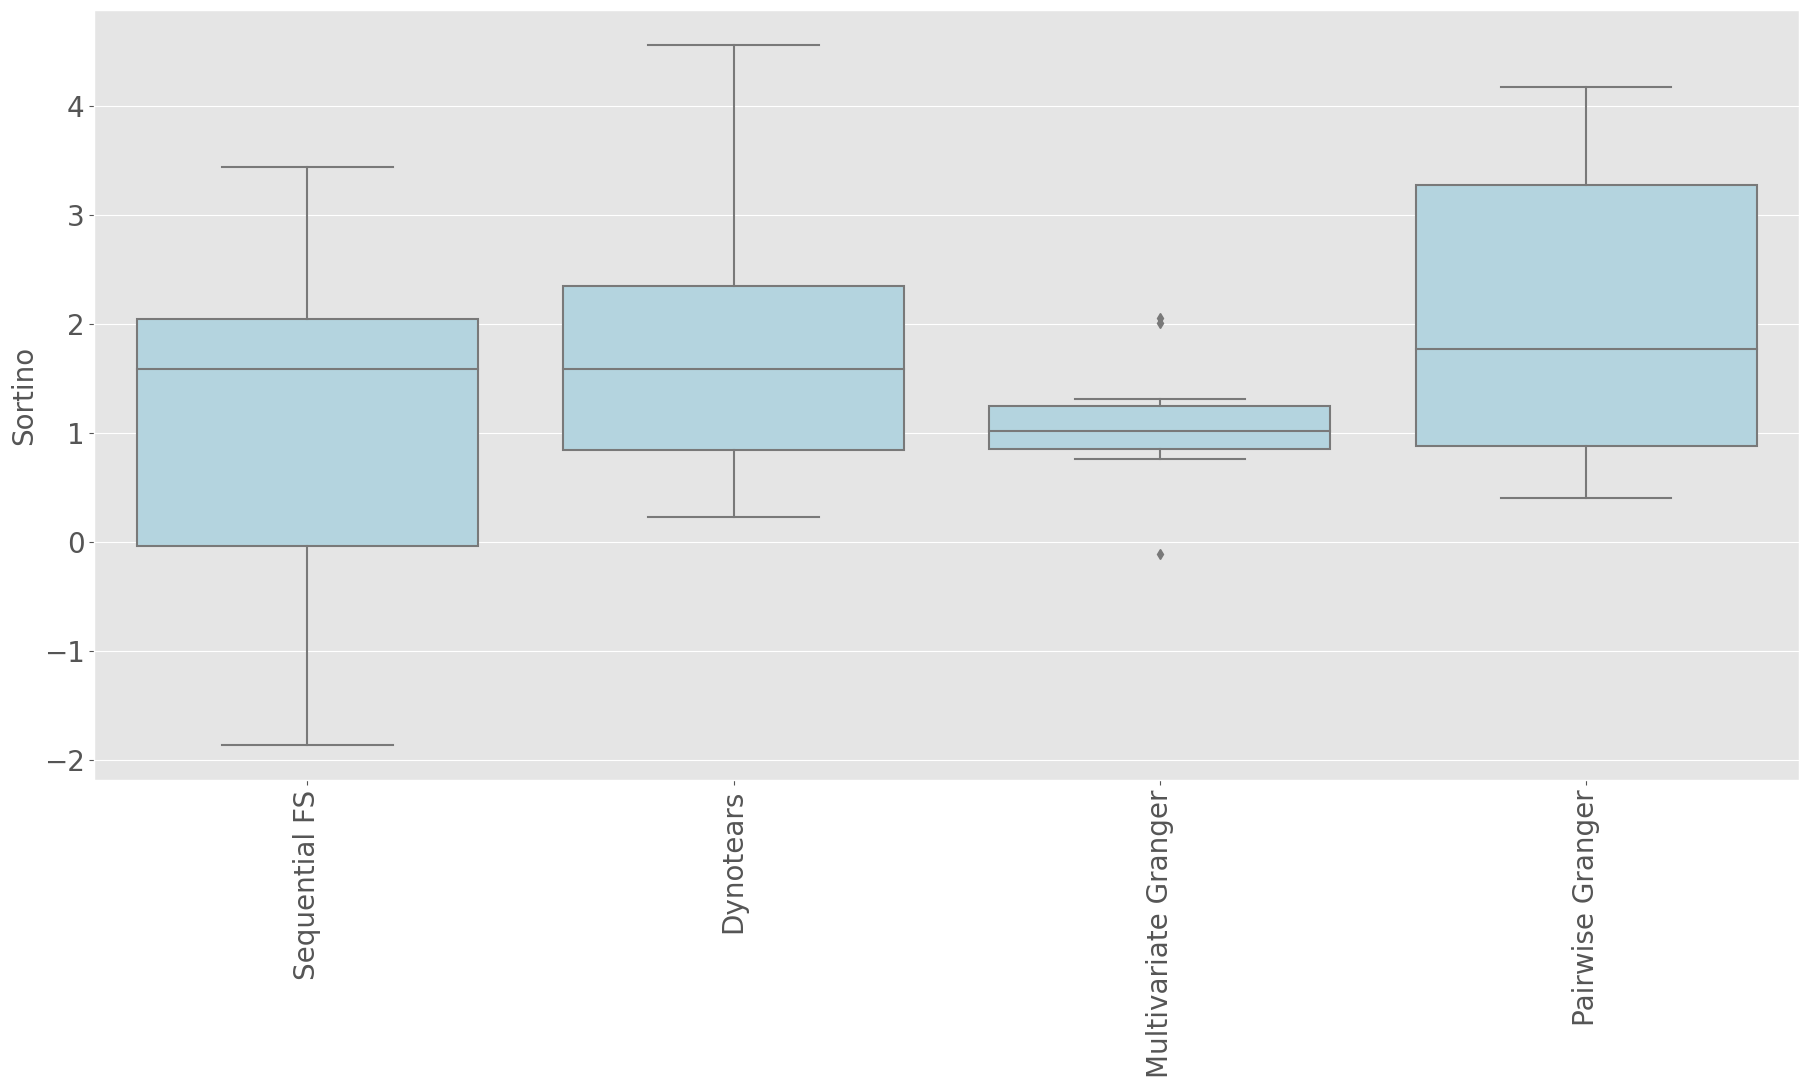

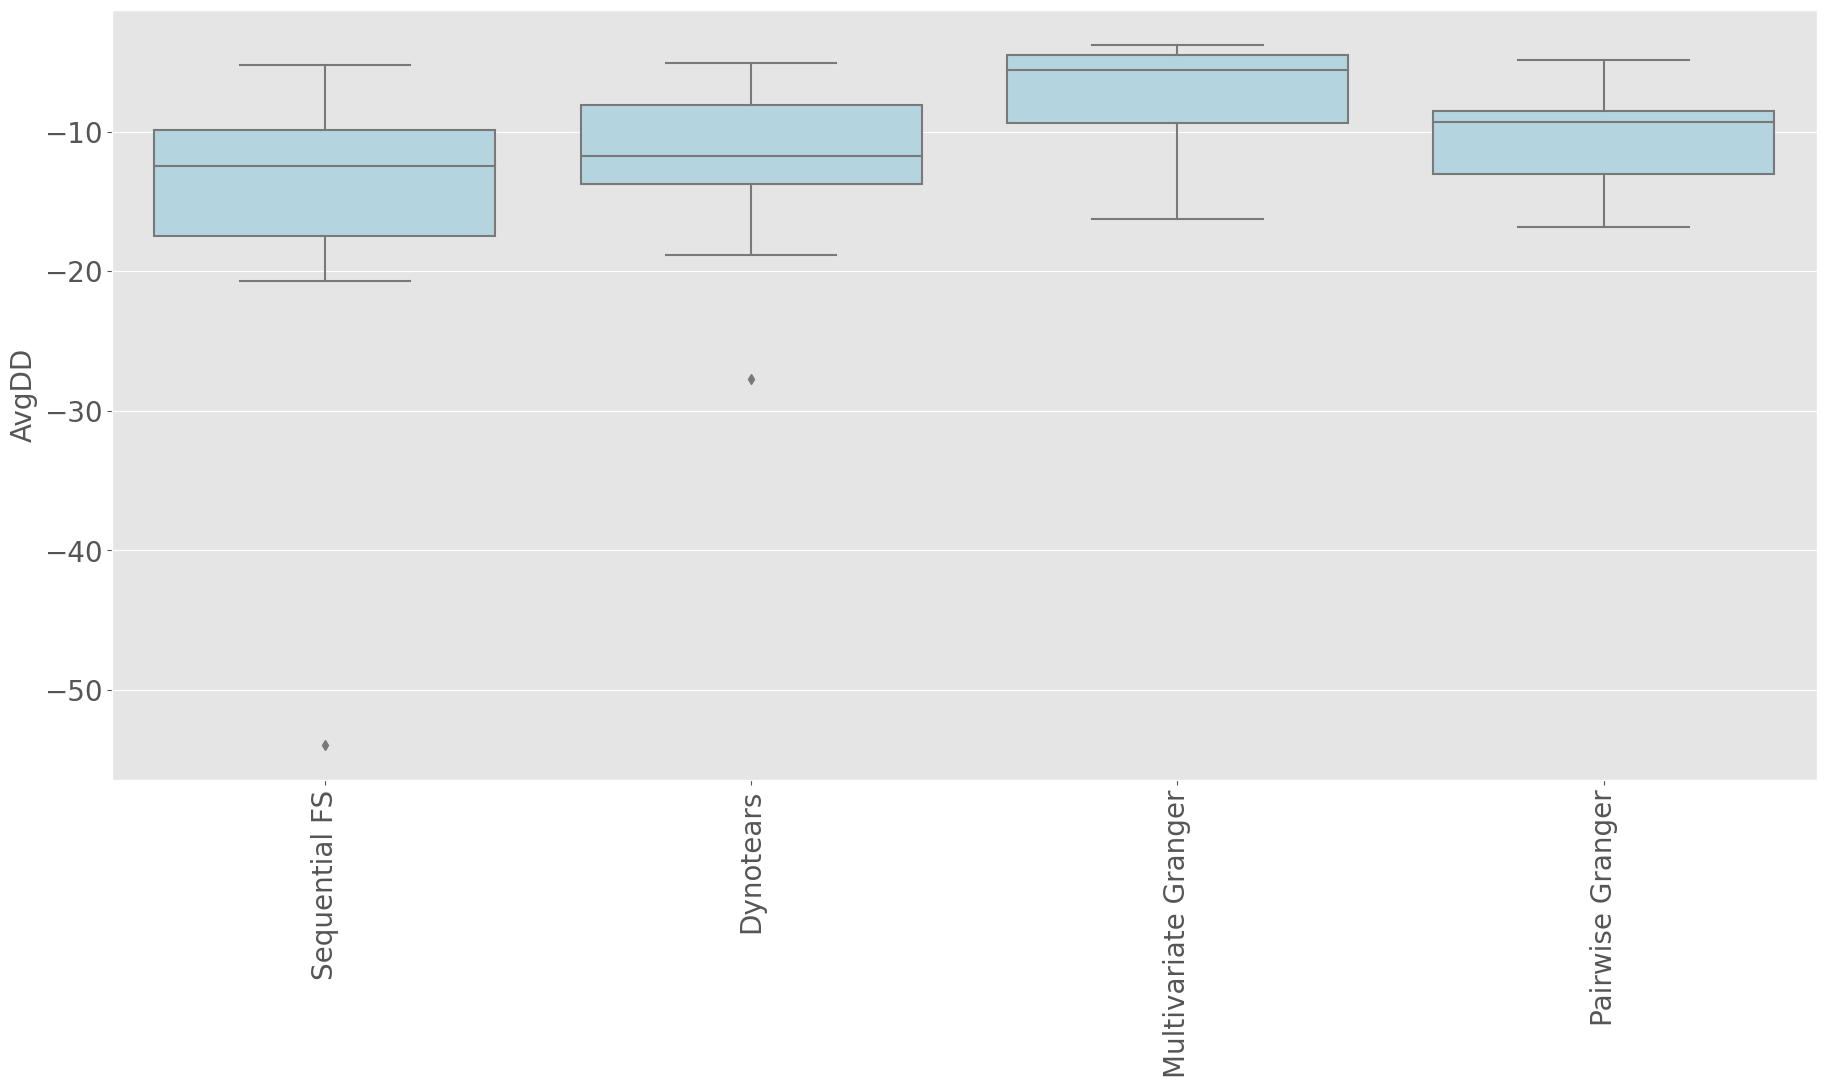

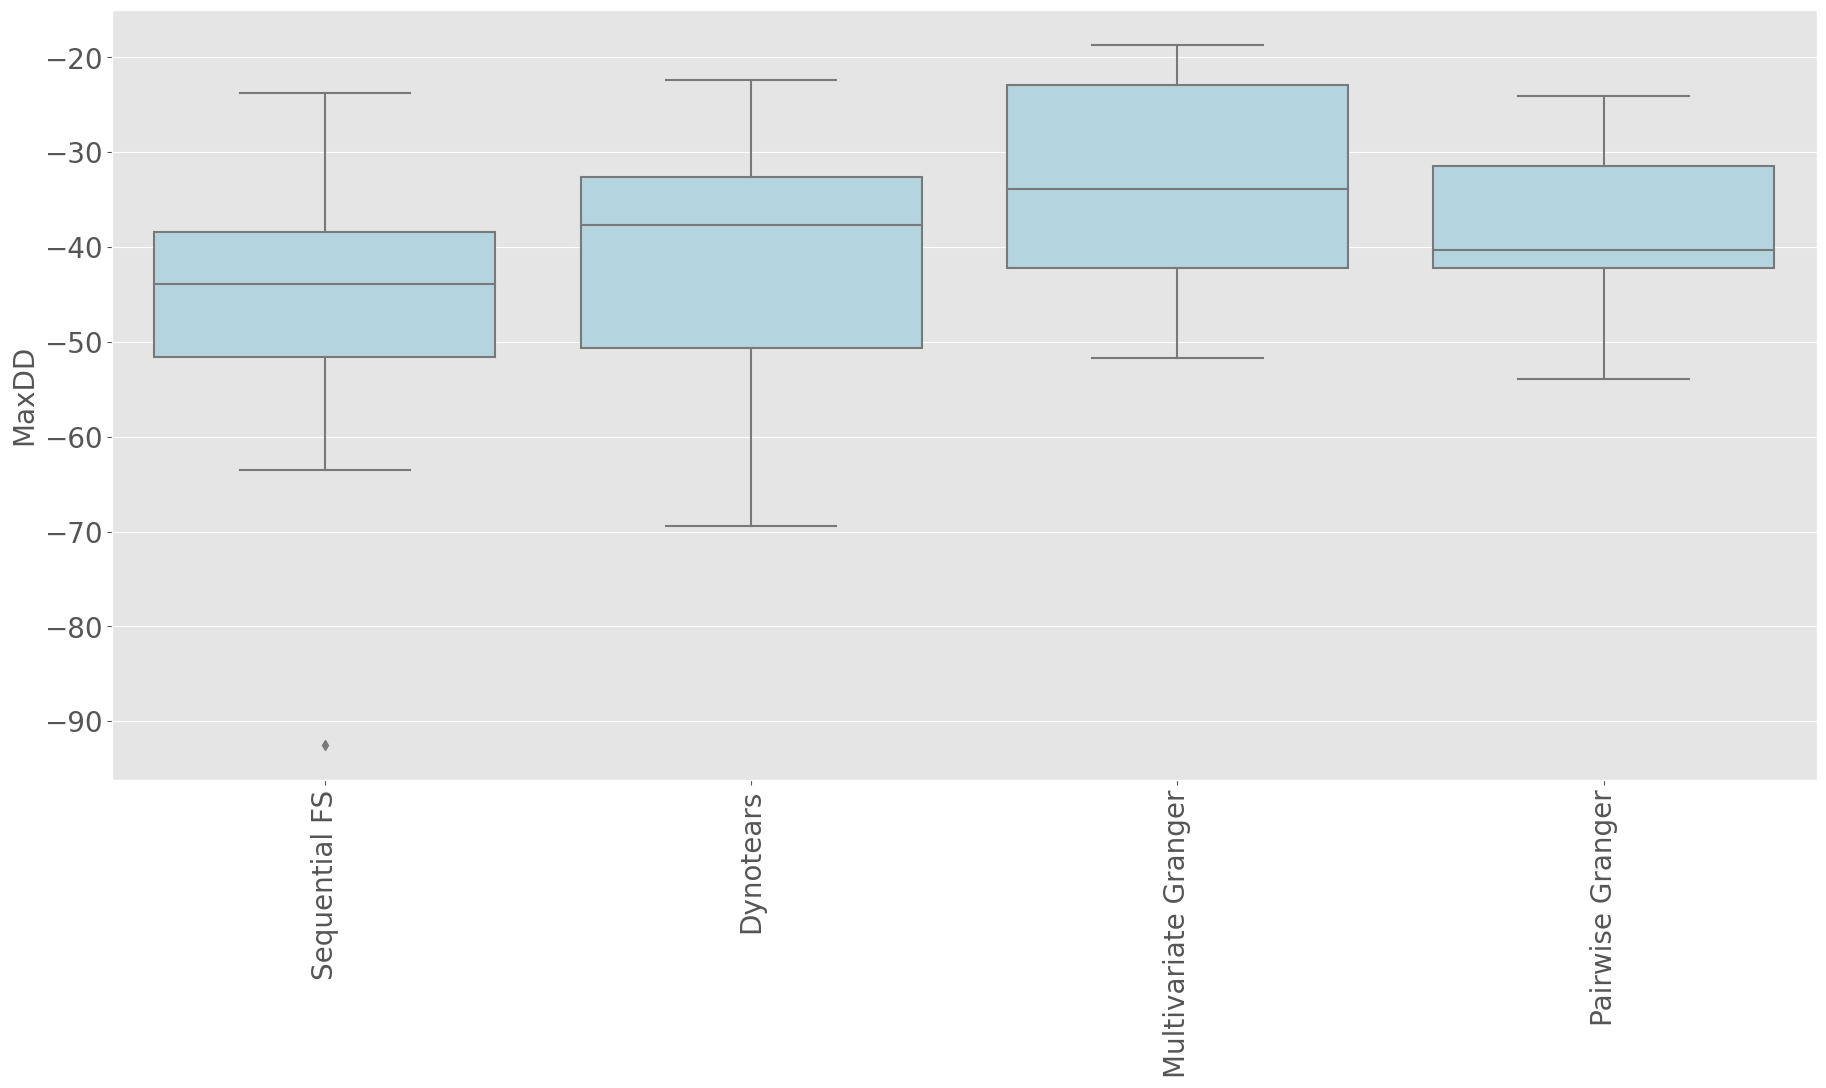

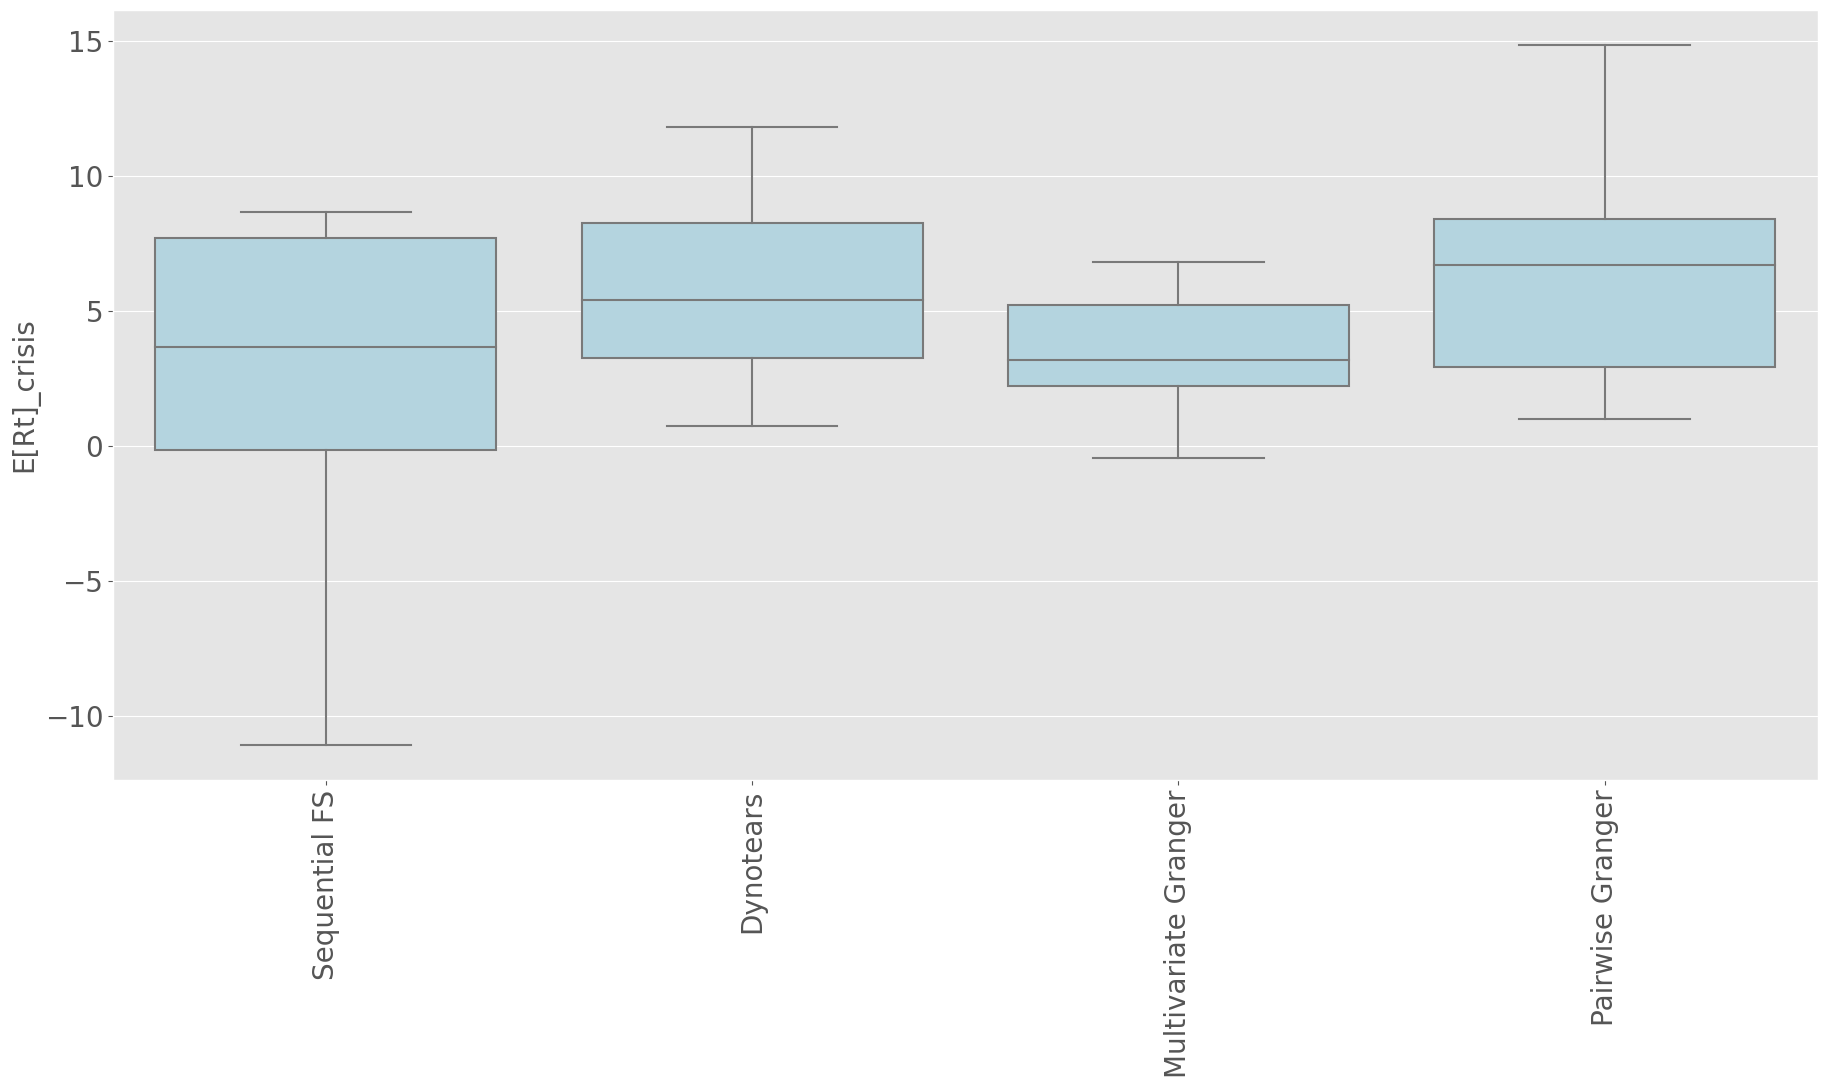

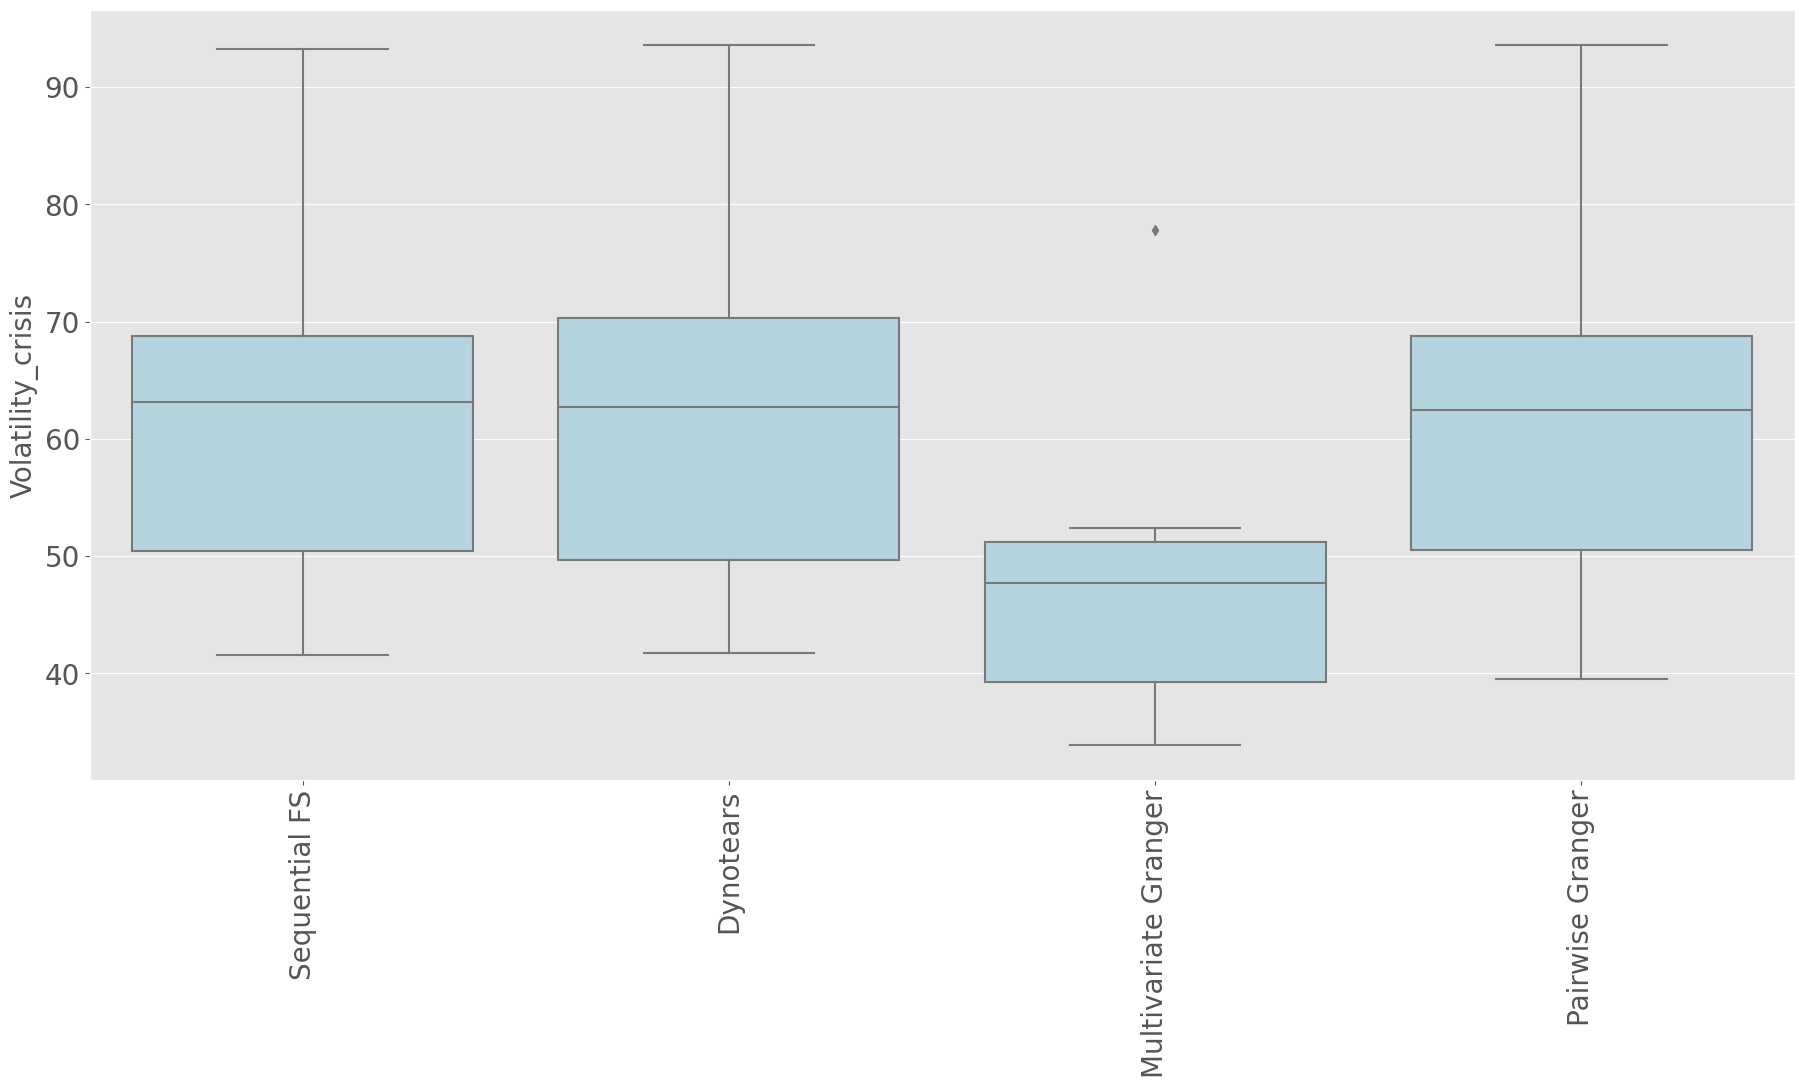

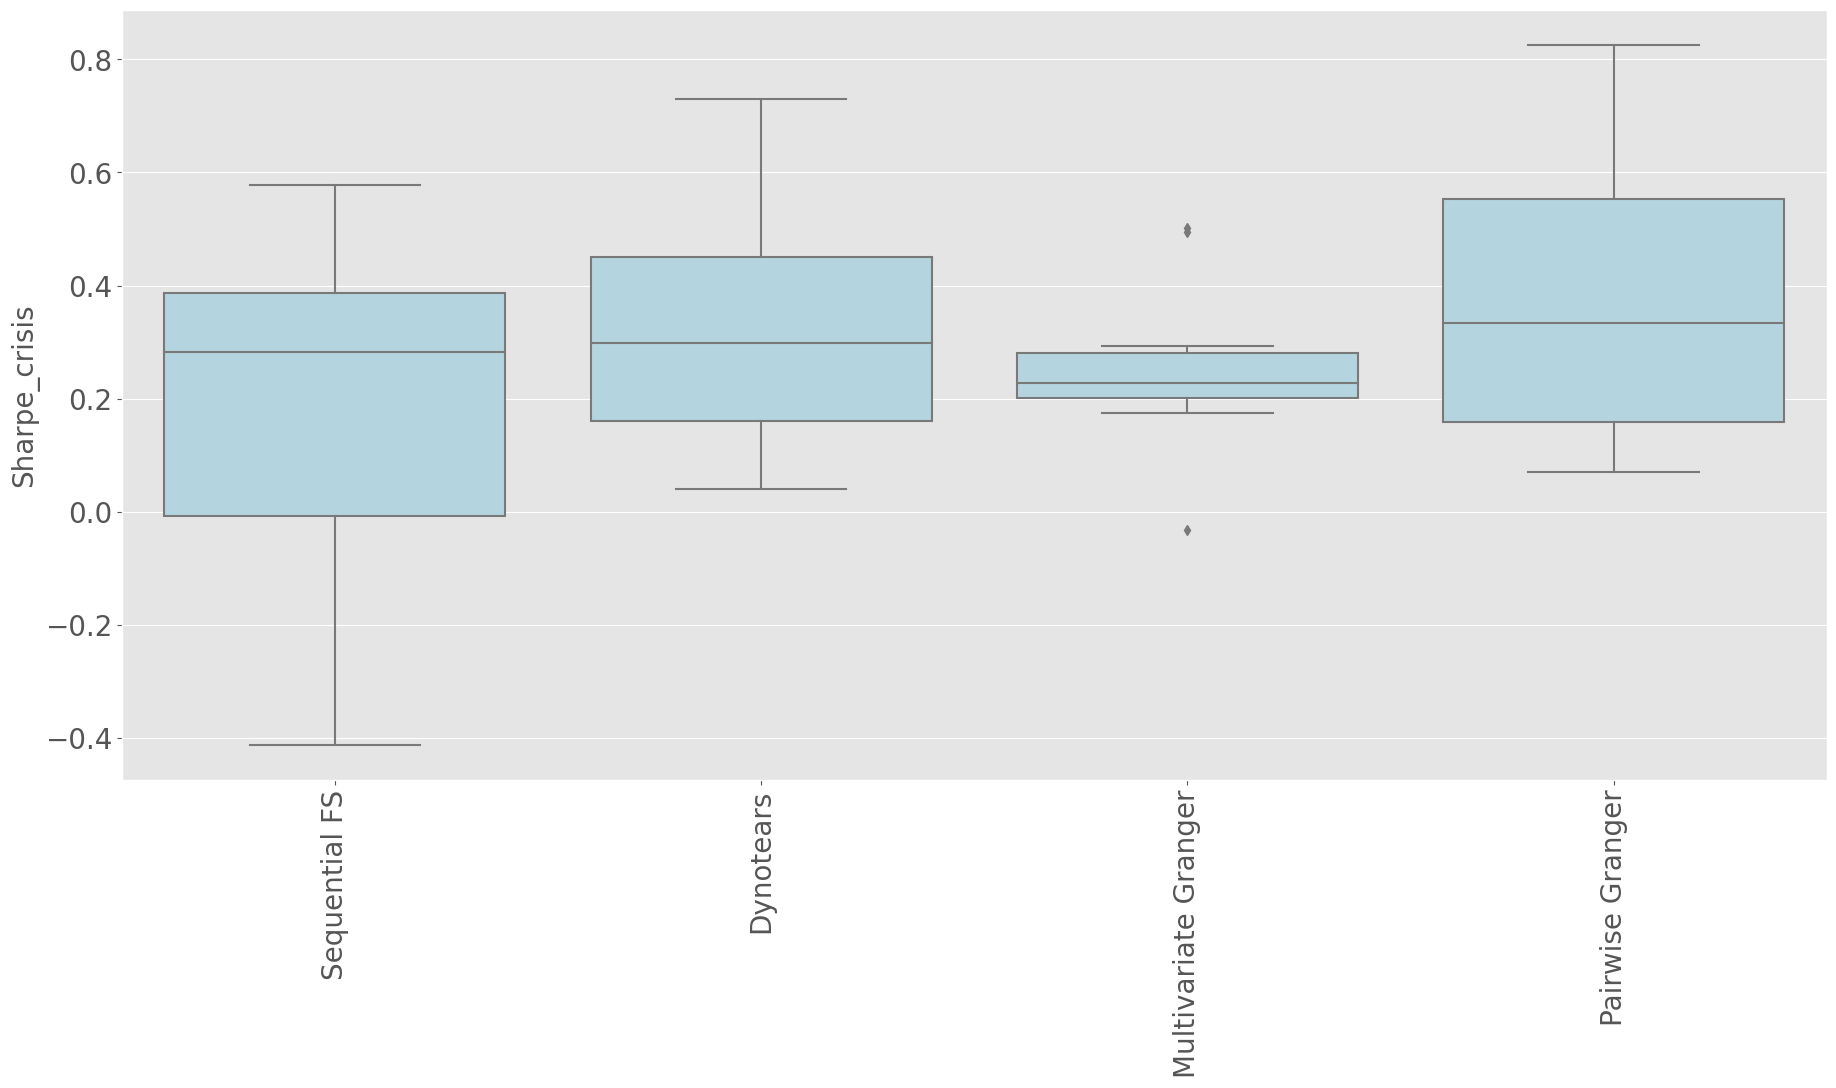

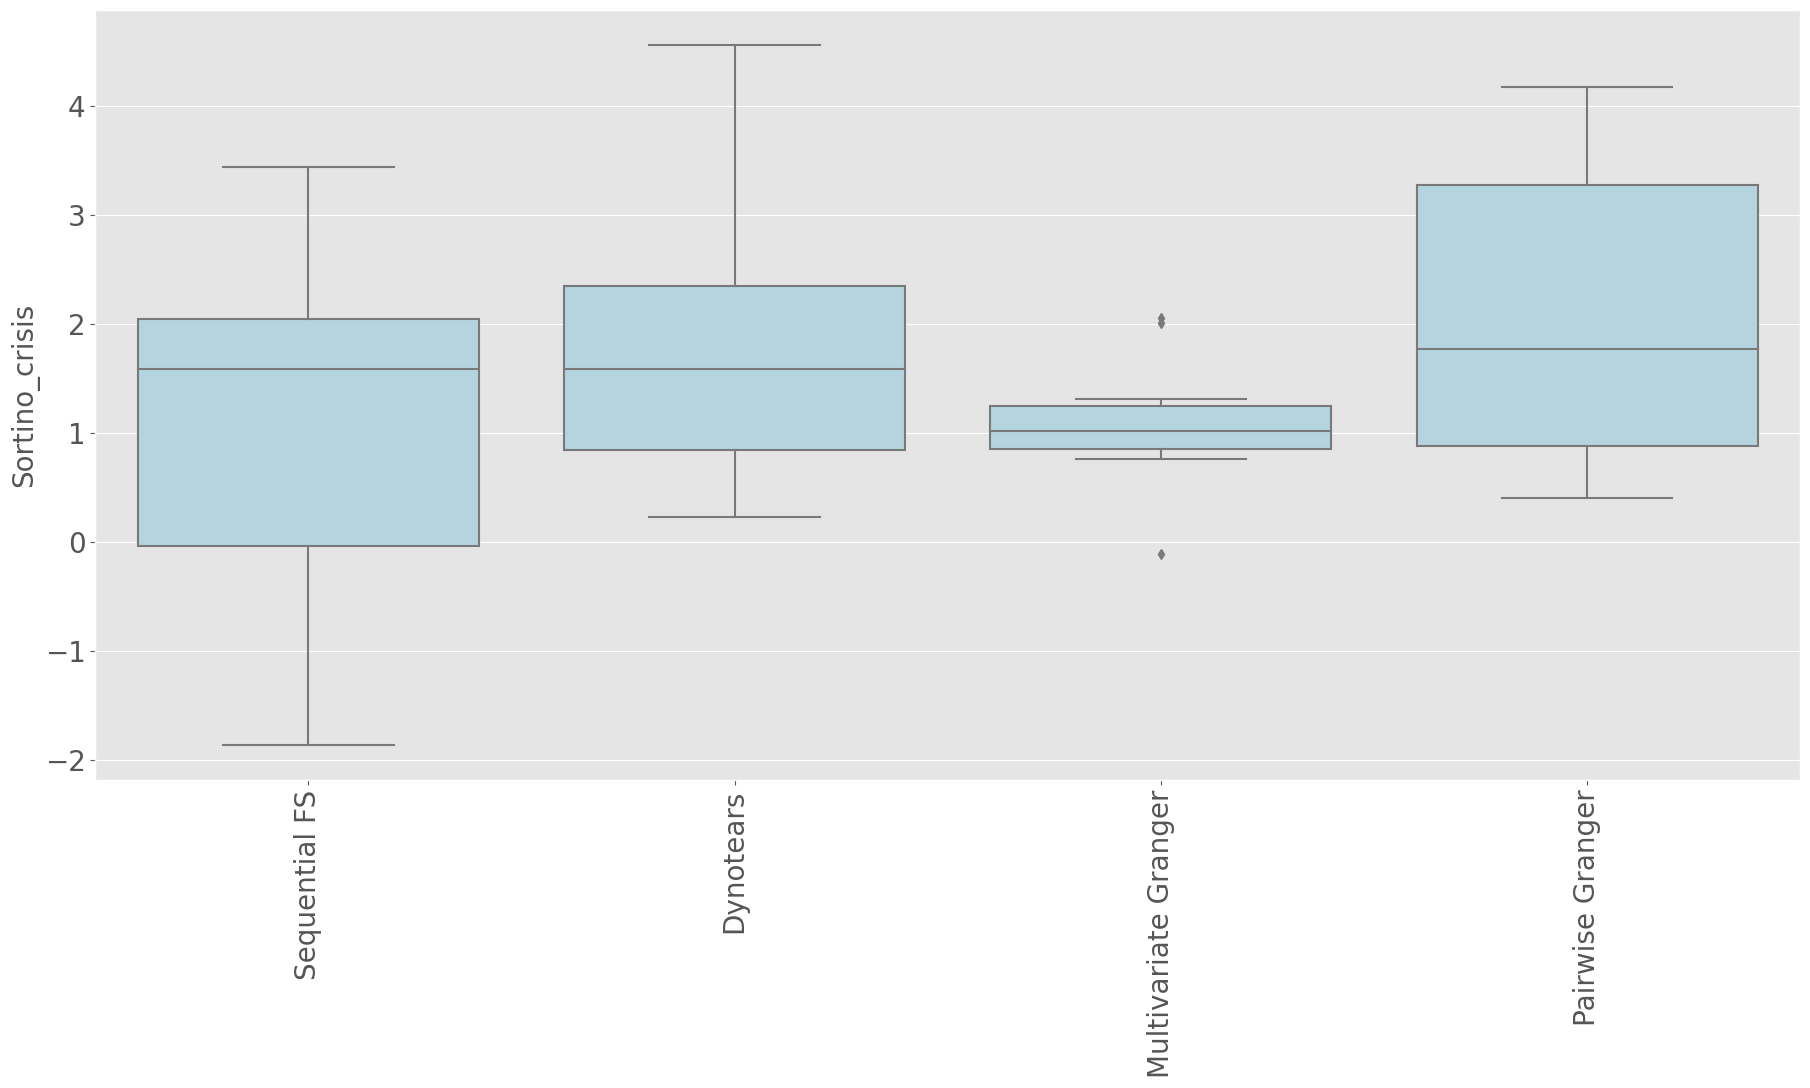

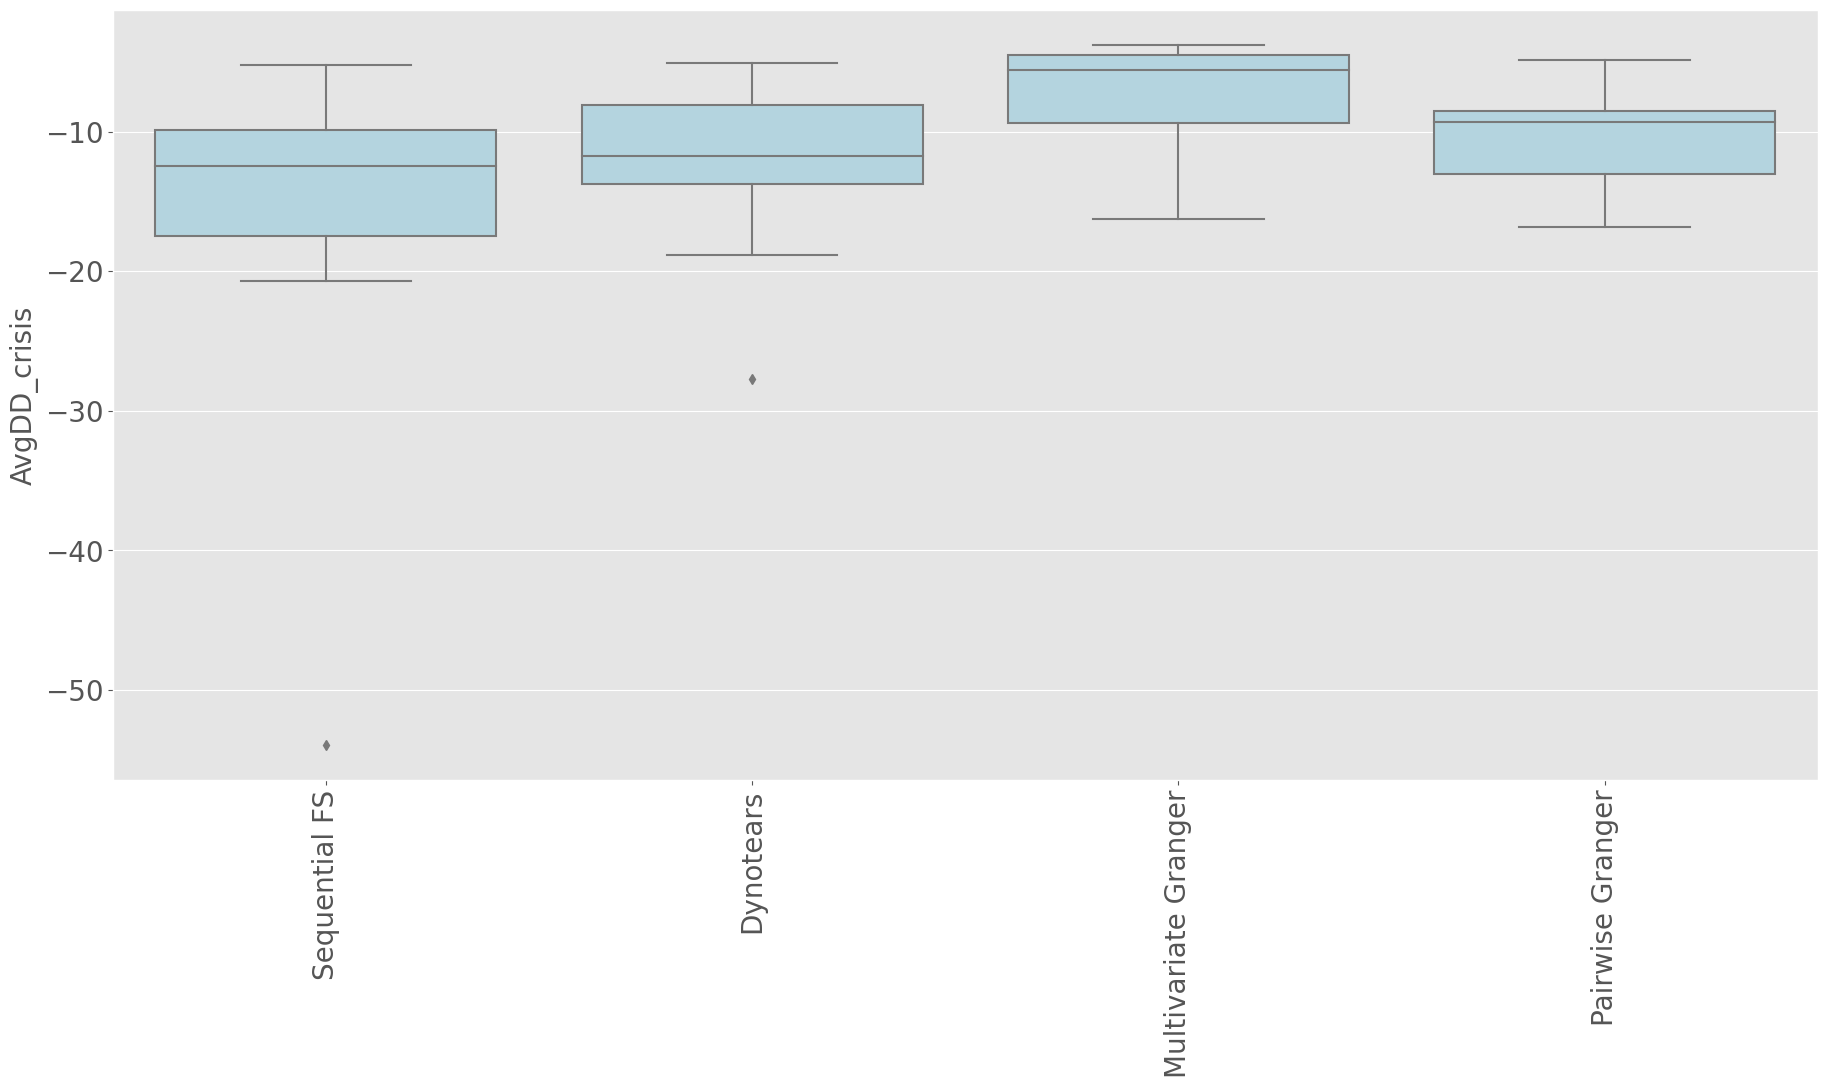

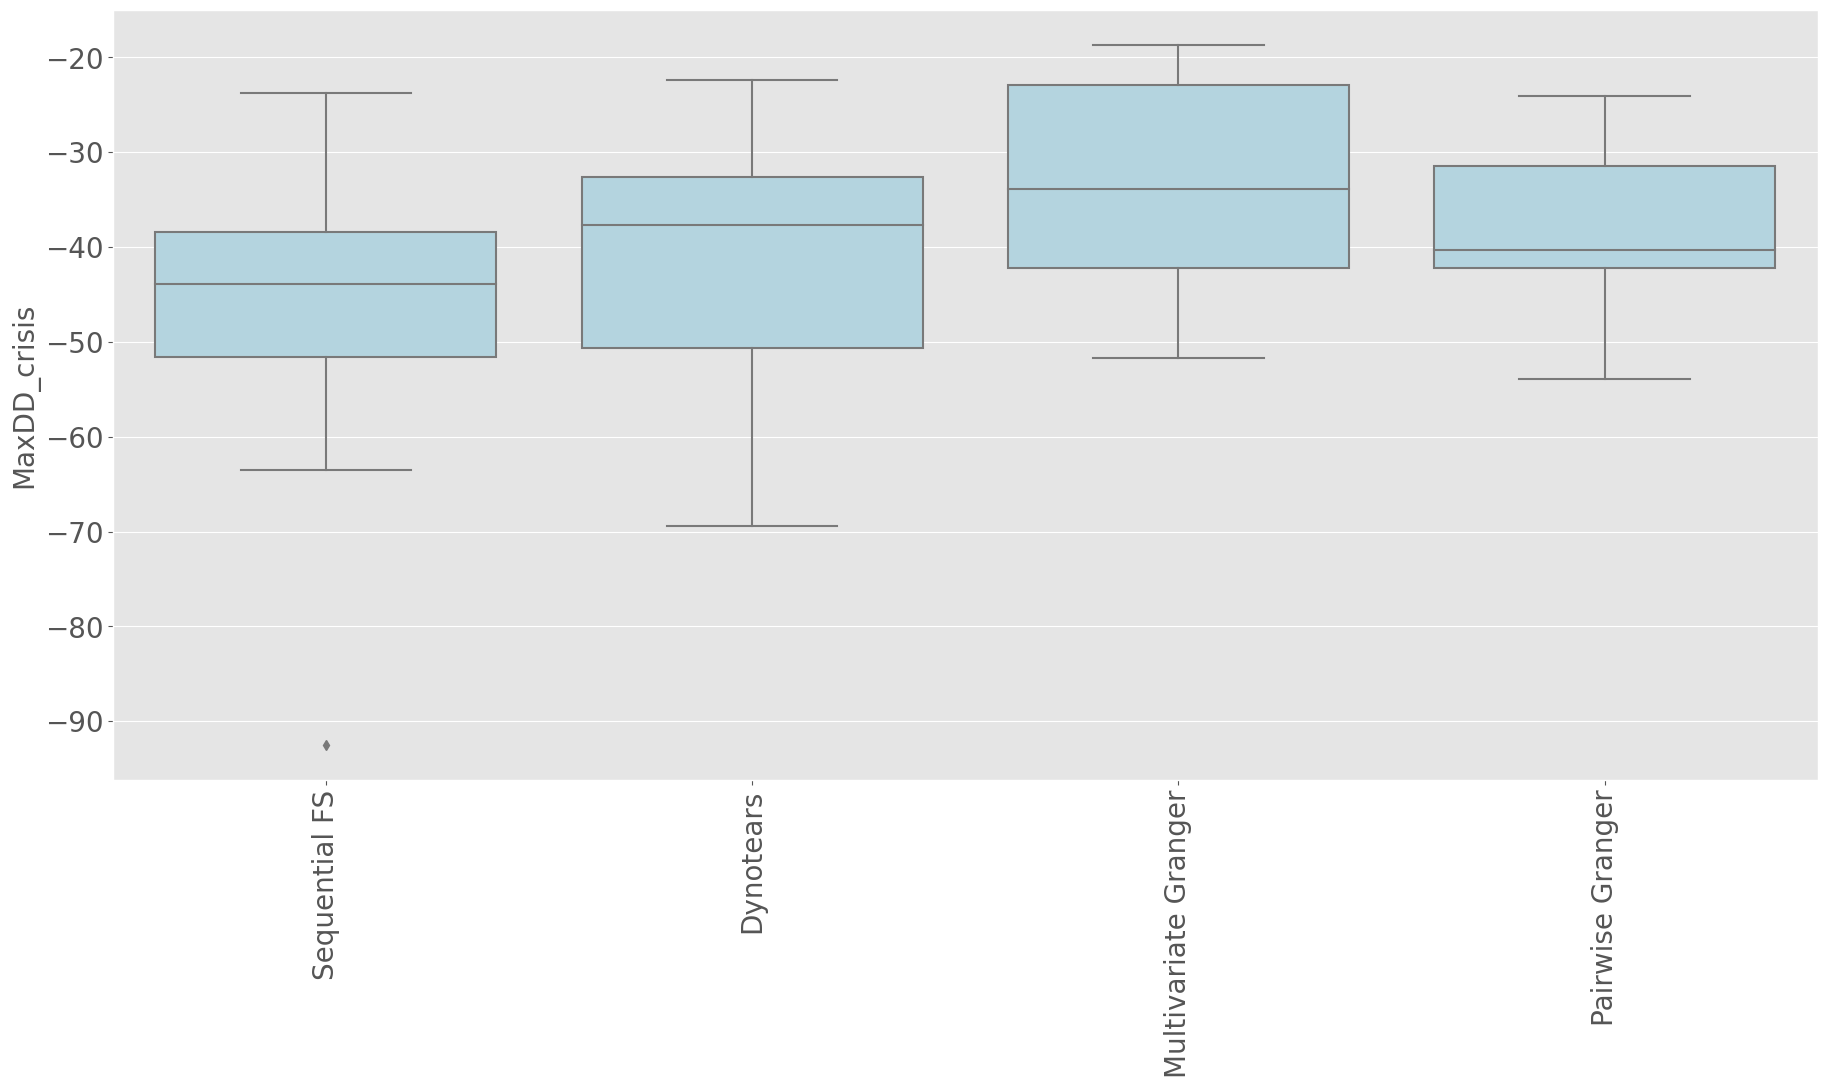

In [16]:
for measure in all_measures_df["variable"].unique():
    boxplot_df = all_measures_df.loc[(all_measures_df["variable"] == measure)&
                                     (~all_measures_df["index"].isin(etfs_large))].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="index", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(measure, fontsize=20)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{measure}_fs.png'))

### Plot Cumulative Returns

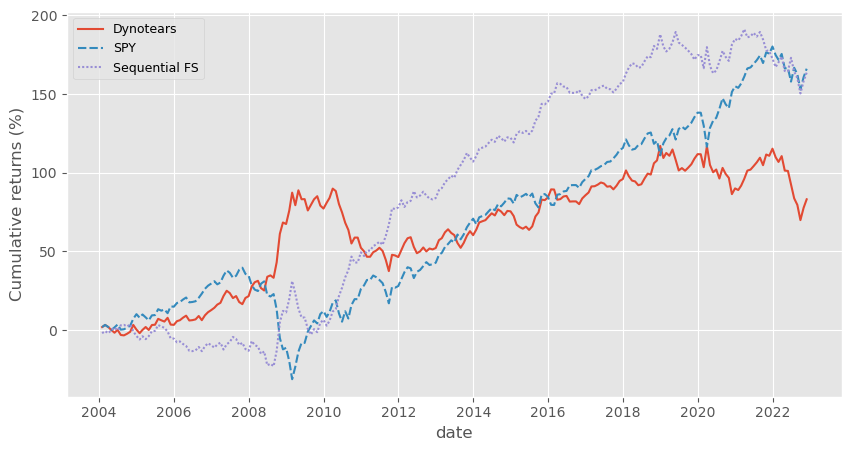

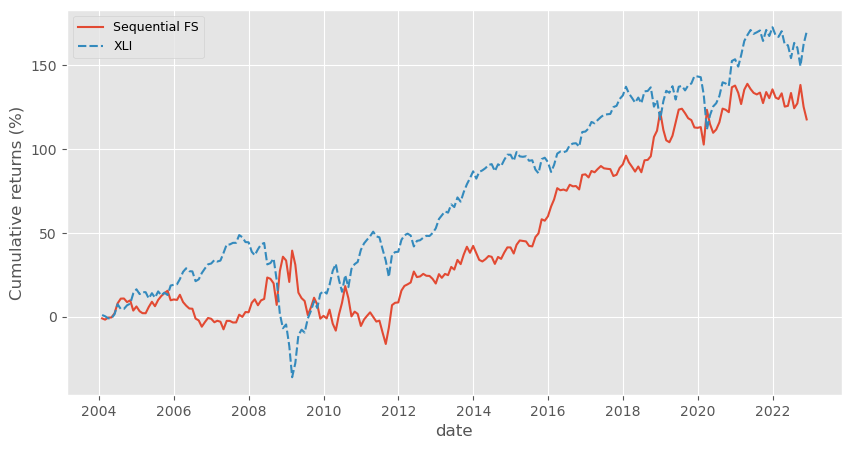

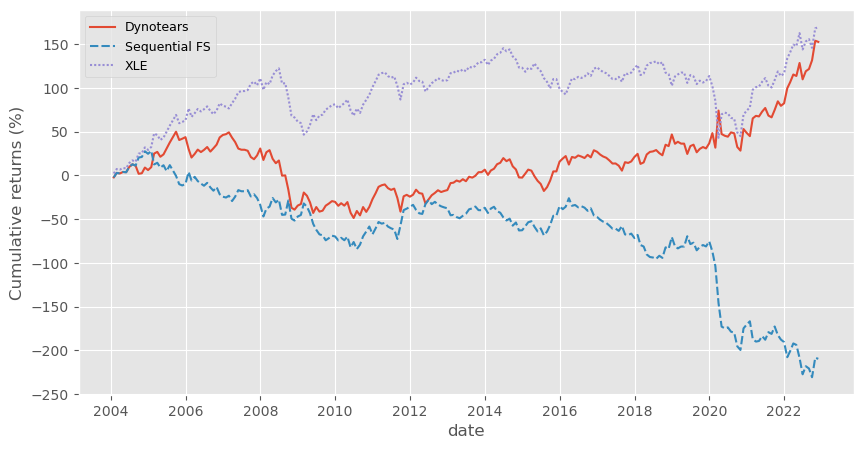

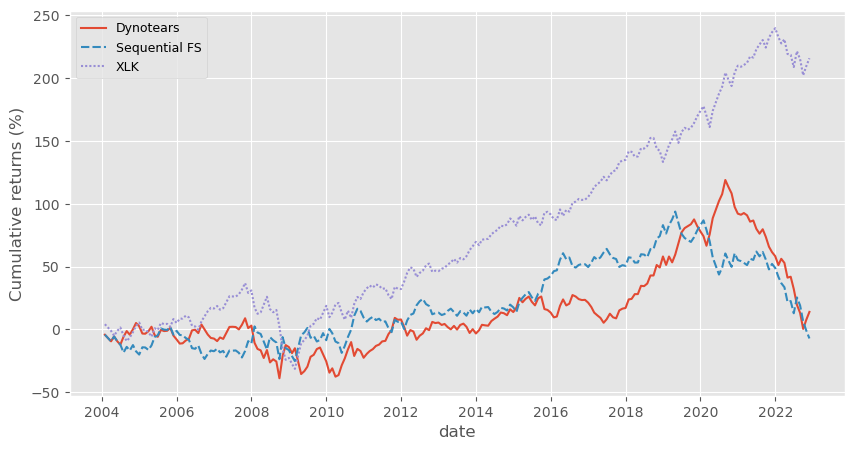

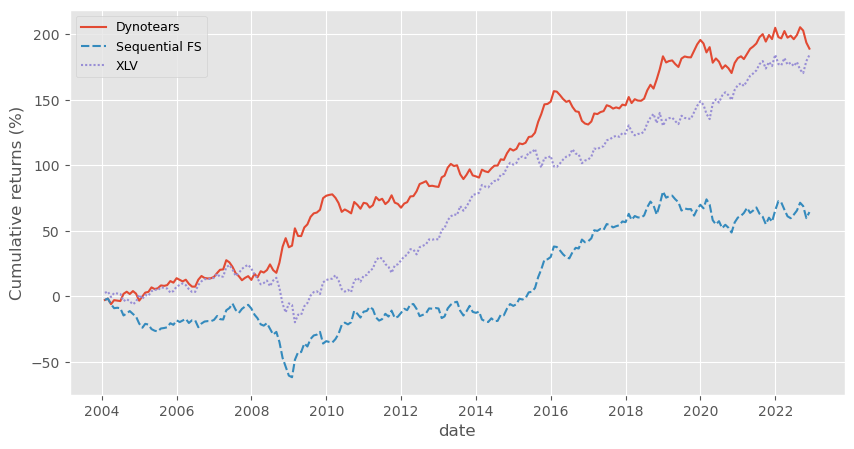

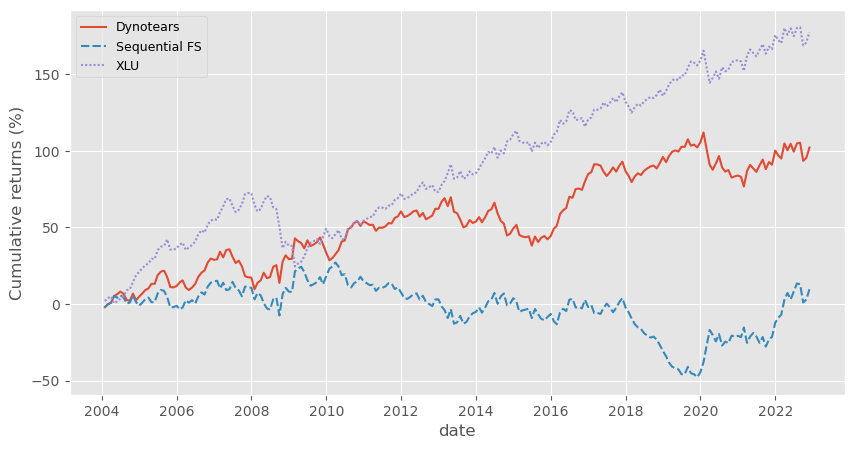

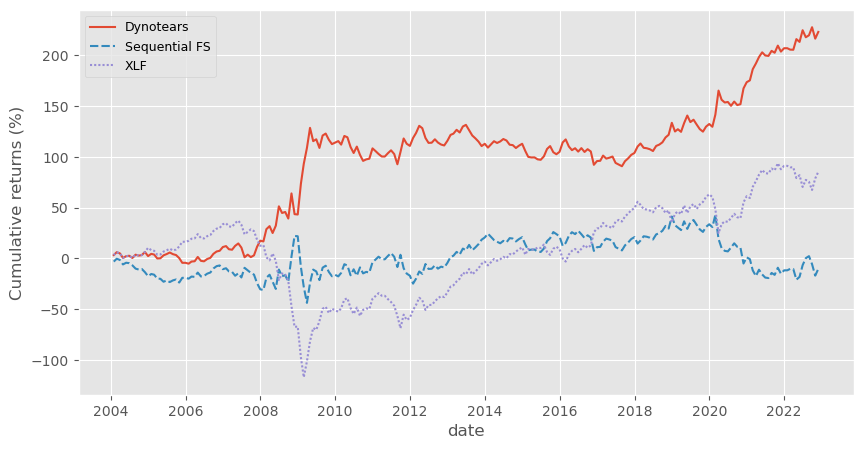

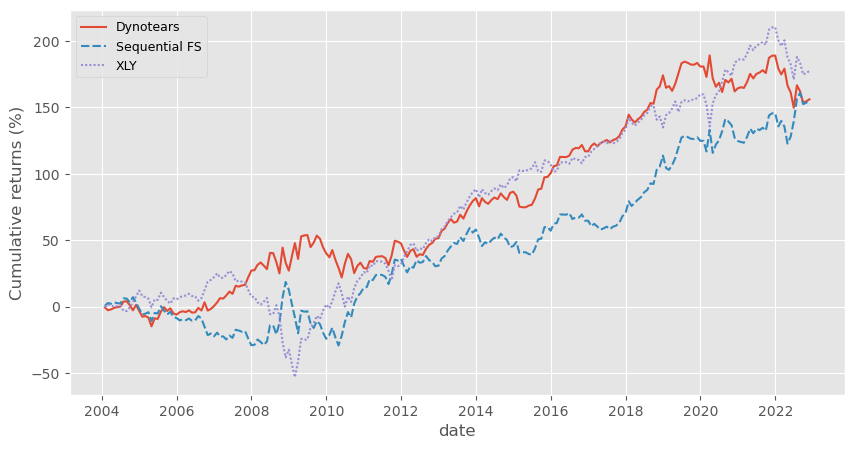

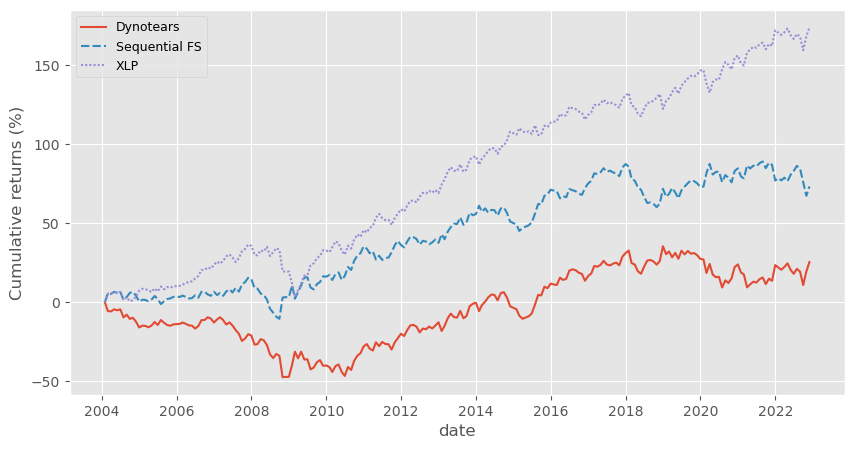

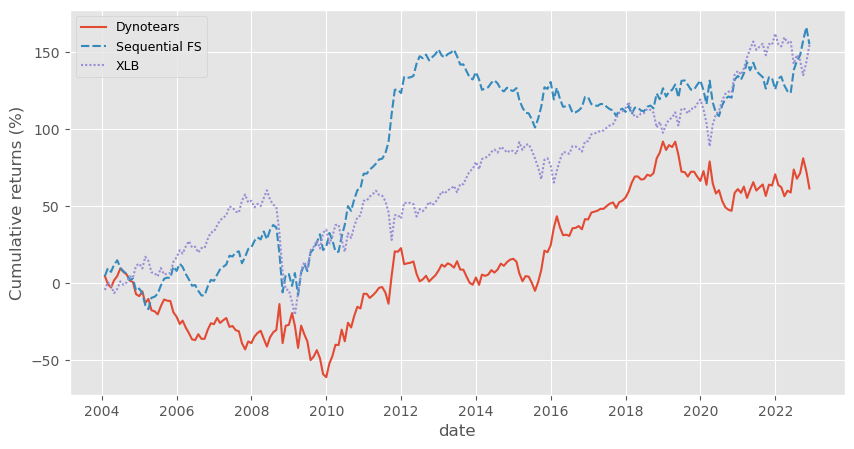

In [12]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()
    tmp_dfPnl.columns.name = ""
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    sns.lineplot(data = tmp_dfPnl.cumsum() * 100, ax = ax)
    ax.set_ylabel("Cumulative returns (%)")
    # ax.set_title(target)
    ax.legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret.png"))

### Plot Rolling Sharpe Ratios

In [13]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    rolling_sharpe_df = tmp_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0).fillna(0)
    rolling_sharpe_diff_df = pd.DataFrame(rolling_sharpe_df["Lasso"] - rolling_sharpe_df["VAR-LiNGAM"], columns=["diff_lasso_var-lingam"])
    rolling_sharpe_diff_df["diff_lasso_dynotears"] = rolling_sharpe_df["Lasso"] - rolling_sharpe_df["Dynotears"]
    rolling_sharpe_diff_df = rolling_sharpe_diff_df.fillna(0)

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = rolling_sharpe_df, ax = ax[0])
    ax[0].set_ylabel("Rolling Sharpe Ratio")
    sns.lineplot(data = rolling_sharpe_diff_df, ax = ax[1])
    ax[1].set_ylabel("Sharpe difference")

    # set position of legend
    ax[0].legend(loc='upper left', prop={'size': 9})
    ax[1].legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_rolling_sharpe_fs.png"))

KeyError: 'Lasso'

### Plot Cumulative Returns and Rolling Sharpe Ratios for Combined Portfolio

In [14]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["Lasso"] + 1/2 * tmp_dfPnl["VAR-LiNGAM"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["Lasso"] + 1/2 * tmp_dfPnl["Dynotears"]
    # tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "Lasso", "lasso_var-lingam", "lasso_dynotears"]].copy()

    new_rolling_sharpe_df = new_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)    

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = new_dfPnl.cumsum() * 100, ax = ax[0])
    ax[0].set_ylabel("Cumulative returns (%)")
    ax[0].set_title(f"Equal Weighted Portfolio of Lasso+ for {target}")

    sns.lineplot(data = new_rolling_sharpe_df, ax = ax[1])
    ax[1].set_ylabel("Rolling Sharpe Ratio")

    ax[0].legend(loc='upper left', prop={'size': 9})
    # ax[1].legend(loc='upper left', prop={'size': 8})
    ax[1].get_legend().remove()

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret_combined.png"))

KeyError: 'Lasso'

### Top Sharpe and MaxDD for the Combined Portfolios per ETF

In [12]:
all_measures = []
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["Lasso"] + 1/2 * tmp_dfPnl["VAR-LiNGAM"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["Lasso"] + 1/2 * tmp_dfPnl["Dynotears"]
    # tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "Lasso", "lasso_var-lingam", "lasso_dynotears"]].copy()

    i = 0
    for tag, measure in metric_funcs.items():
        measure_values = measure(new_dfPnl)

        if i == 0:
            tmp_measure = pd.DataFrame(measure_values, columns=[tag])
        else:
            tmp_measure[tag] = measure_values
        i += 1
    
    tmp_measure["etf"] = target
    tmp_measure = tmp_measure.reset_index().set_index(["etf", "variable"])

    all_measures.append(tmp_measure)

all_measures_df = pd.concat(all_measures, axis=0)
melt_all_measures_df = all_measures_df.reset_index().rename(columns={"variable": "fs"}).melt(id_vars=["etf", "fs"])

In [13]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2)

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                          
SPY lasso_var-lingam   8.09       45.86    0.61     2.57  -3.56 -18.54
    SPY                8.78       51.81    0.59     2.52  -6.50 -50.78
XLB lasso_dynotears    7.63       50.67    0.52     2.59  -6.24 -21.51
    XLB                8.17       69.93    0.40     1.84  -8.34 -55.44
XLE lasso_var-lingam  12.03       78.72    0.53     2.36 -11.03 -34.21
    Lasso             11.24       93.14    0.42     2.17 -16.89 -54.03
XLF XLF                4.51       77.80    0.20     0.78 -23.96 -78.63
    lasso_var-lingam   1.35       67.08    0.07     0.29 -43.26 -69.63
XLI XLI                8.98       65.05    0.48     1.97  -7.09 -57.15
    lasso_var-lingam   4.60       49.92    0.32     1.33  -6.04 -22.70
XLK XLK               11.40       61.70    0.64     3.15  -6.87 -49.45
    lasso_var-lingam   7.54       51.37    0.51     2.14  -9.99 -31.72
XLP XLP                9.19       40.72    0.78     3.62  -2.90 -28.13
    lasso_dynotears    5.95       33.78    0.61     2.46  -3.13 -18.61
XLU XLU                9.38       49.03    0.66     2.85  -6.59 -38.03
    lasso_dynotears    5.64       41.89    0.47     2.00  -7.99 -28.02
XLV XLV                9.73       47.43    0.71     3.55  -5.05 -35.49
    lasso_dynotears    5.68       37.57    0.52     2.25  -4.83 -24.19
XLY lasso_dynotears    9.53       54.22    0.61     2.47  -6.11 -28.52
    XLY                9.38       63.36    0.51     2.37  -7.25 -55.07

In [14]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &     &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & lasso\_var-lingam &   8.09 &       45.86 &    0.61 &     2.57 &  -3.56 & -18.54 \\
    & SPY &   8.78 &       51.81 &    0.59 &     2.52 &  -6.50 & -50.78 \\
XLB & lasso\_dynotears &   7.63 &       50.67 &    0.52 &     2.59 &  -6.24 & -21.51 \\
    & XLB &   8.17 &       69.93 &    0.40 &     1.84 &  -8.34 & -55.44 \\
XLE & lasso\_var-lingam &  12.03 &       78.72 &    0.53 &     2.36 & -11.03 & -34.21 \\
    & Lasso &  11.24 &       93.14 &    0.42 &     2.17 & -16.89 & -54.03 \\
XLF & XLF &   4.51 &       77.80 &    0.20 &     0.78 & -23.96 & -78.63 \\
    & lasso\_var-lingam &   1.35 &       67.08 &    0.07 &     0.29 & -43.26 & -69.63 \\
XLI & XLI &   8.98 &       65.05 &    0.48 &     1.97 &  -7.09 & -57.15 \\
    & lasso\_var-lingam &   4.60 &       49.92 &    0.32 &     1.33 &

In [15]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                          
SPY lasso_var-lingam   8.09       45.86    0.61     2.57  -3.56 -18.54
    Lasso              6.81       52.10    0.45     2.40  -6.18 -23.64
XLB lasso_dynotears    7.63       50.67    0.52     2.59  -6.24 -21.51
    lasso_var-lingam   2.71       53.13    0.18     0.71 -21.73 -47.20
XLE lasso_var-lingam  12.03       78.72    0.53     2.36 -11.03 -34.21
    Lasso             11.24       93.14    0.42     2.17 -16.89 -54.03
XLF Lasso             -0.71       77.58   -0.03    -0.15 -39.45 -67.04
    lasso_dynotears   -1.11       65.41   -0.06    -0.24 -40.80 -67.16
XLI lasso_var-lingam   4.60       49.92    0.32     1.33  -6.04 -22.70
    lasso_dynotears    3.34       55.86    0.21     0.80  -9.69 -42.38
XLK lasso_var-lingam   7.54       51.37    0.51     2.14  -9.99 -31.72
    lasso_dynotears    5.88       53.42    0.38     2.01 -13.67 -42.25
XLP lasso_var-lingam   5.43       34.61    0.54     2.30  -3.79 -16.63
    lasso_dynotears    5.95       33.78    0.61     2.46  -3.13 -18.61
XLU lasso_dynotears    5.64       41.89    0.47     2.00  -7.99 -28.02
    lasso_var-lingam   5.73       44.57    0.45     2.06  -7.93 -29.00
XLV lasso_var-lingam   4.27       40.68    0.36     1.60  -7.67 -20.68
    lasso_dynotears    5.68       37.57    0.52     2.25  -4.83 -24.19
XLY lasso_dynotears    9.53       54.22    0.61     2.47  -6.11 -28.52
    lasso_var-lingam   6.55       52.98    0.43     1.70  -8.42 -30.69

In [16]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &                  &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & lasso\_var-lingam &   8.09 &       45.86 &    0.61 &     2.57 &  -3.56 & -18.54 \\
    & Lasso &   6.81 &       52.10 &    0.45 &     2.40 &  -6.18 & -23.64 \\
XLB & lasso\_dynotears &   7.63 &       50.67 &    0.52 &     2.59 &  -6.24 & -21.51 \\
    & lasso\_var-lingam &   2.71 &       53.13 &    0.18 &     0.71 & -21.73 & -47.20 \\
XLE & lasso\_var-lingam &  12.03 &       78.72 &    0.53 &     2.36 & -11.03 & -34.21 \\
    & Lasso &  11.24 &       93.14 &    0.42 &     2.17 & -16.89 & -54.03 \\
XLF & Lasso &  -0.71 &       77.58 &   -0.03 &    -0.15 & -39.45 & -67.04 \\
    & lasso\_dynotears &  -1.11 &       65.41 &   -0.06 &    -0.24 & -40.80 & -67.16 \\
XLI & lasso\_var-lingam &   4.60 &       49.92 &    0.32 &     1.33 &  -6.04 & -22.70 \\
    & lasso\_dynotears & 

In [17]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "AvgDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                          
SPY lasso_var-lingam   8.09       45.86    0.61     2.57  -3.56 -18.54
    lasso_dynotears    7.31       45.90    0.55     2.34  -4.21 -24.33
XLB lasso_dynotears    7.63       50.67    0.52     2.59  -6.24 -21.51
    XLB                8.17       69.93    0.40     1.84  -8.34 -55.44
XLE lasso_var-lingam  12.03       78.72    0.53     2.36 -11.03 -34.21
    Lasso             11.24       93.14    0.42     2.17 -16.89 -54.03
XLF XLF                4.51       77.80    0.20     0.78 -23.96 -78.63
    Lasso             -0.71       77.58   -0.03    -0.15 -39.45 -67.04
XLI lasso_var-lingam   4.60       49.92    0.32     1.33  -6.04 -22.70
    XLI                8.98       65.05    0.48     1.97  -7.09 -57.15
XLK XLK               11.40       61.70    0.64     3.15  -6.87 -49.45
    lasso_var-lingam   7.54       51.37    0.51     2.14  -9.99 -31.72
XLP XLP                9.19       40.72    0.78     3.62  -2.90 -28.13
    lasso_dynotears    5.95       33.78    0.61     2.46  -3.13 -18.61
XLU XLU                9.38       49.03    0.66     2.85  -6.59 -38.03
    lasso_var-lingam   5.73       44.57    0.45     2.06  -7.93 -29.00
XLV lasso_dynotears    5.68       37.57    0.52     2.25  -4.83 -24.19
    XLV                9.73       47.43    0.71     3.55  -5.05 -35.49
XLY lasso_dynotears    9.53       54.22    0.61     2.47  -6.11 -28.52
    XLY                9.38       63.36    0.51     2.37  -7.25 -55.07